# Lab 2: Text Analysis and Preprocessing Pipeline

## Notebook Overview

This notebook provides a comprehensive workflow for text data analysis and preprocessing.

We cover three main areas:

1. **Data Loading and Exploration**: We set up our environment, load and explore the tweet-topic dataset, perform statistical analysis, and develop reusable data loading functions.

2. **Text Preprocessing**: We apply various NLP preprocessing techniques using NLTK and spaCy, analyze how the order of operations affects results, critically evaluate each method's utility, and develop a reusable preprocessing pipeline.

3. **Dataset Preparation**: We create both multi-label and single-label versions of our dataset for use in subsequent classification labs (Lab 4, Lab 5).

Throughout this notebook, we cover key preprocessing concepts including tokenization, normalization (stemming vs. lemmatization), stop word removal, and the handling of special characters in social media text.

## Output Files

This notebook produces the following datasets:

**Multi-Label Datasets:**
- `../Data/multi_label/tweets_preprocessed_train.parquet`
- `../Data/multi_label/tweets_preprocessed_test.parquet`
- `../Data/multi_label/tweets_preprocessed_validation.parquet`

**Single-Label Datasets:**
- `../Data/single_label/tweets_single_label_train.parquet`
- `../Data/single_label/tweets_single_label_test.parquet`
- `../Data/single_label/tweets_single_label_validation.parquet`

---

## 1. Data Loading and Exploration

In this section, we load our dataset and perform exploratory analysis. Before applying any NLP techniques, we must first understand our data: its structure, quality, and characteristics.

**Key principle:** Text data must be examined for encoding issues, structural patterns, and quality before analysis. An initial visual inspection provides clarity about potential problems.

We will:
- Load the dataset into a pandas DataFrame
- Explore its structure using both NLTK and spaCy
- Calculate comprehensive statistics
- Filter to text-only content
- Create reusable functions for future labs

### 1.1 Load and Explore Dataset

Loading the dataset into a pandas DataFrame and performing initial exploration. This includes viewing the first few rows, checking data types, examining the shape of the dataset, and identifying any missing values.

#### 1.1.1 Basic Dataset Overview

In [37]:
import pandas as pd
from datasets import load_dataset

# Load the dataset directly from Hugging Face using the datasets library
dataset = load_dataset("cardiffnlp/tweet_topic_multi", split="train_all")

# Convert to pandas DataFrame
df = dataset.to_pandas()

# Display basic information
print("Row count, Column count:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nFirst 10 Rows:")
display(df.head(10))

Row count, Column count: (6090, 5)

Column Names: ['text', 'date', 'label', 'label_name', 'id']

Data Types:
text          object
date          object
label         object
label_name    object
id            object
dtype: object

Missing Values:
text          0
date          0
label         0
label_name    0
id            0
dtype: int64

First 10 Rows:


,text,date,label,label_name,id
0,The {@Clinton LumberKings@} beat the {@Cedar R...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170516324419866624
1,I would rather hear Eli Gold announce this Aub...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170516440690176006
2,"Someone take my phone away, I’m trying to not ...",2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170516543387709440
3,"A year ago, Louisville struggled to beat an FC...",2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170516620466429953
4,Anyone know why the #Dodgers #Orioles game nex...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170516711411310592
5,"I don’t care. you gave him a shot, he is strug...",2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170516891053580288
6,Okay how can I watch the {@Arkansas State Foot...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170516916554936322
7,Check out largest crowds ever for a basketball...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[sports],1170516940902805504
8,I voted #WeWantNCAAFootball on {{USERNAME}} . ...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[gaming, sports]",1170517092489187328
9,Streaming a new game #minionmasters come stop ...,2019-09-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",[gaming],1170546366566846464


**Interpretation:** The dataset contains **6,090 tweets** with a clean structure—5 columns (`text`, `date`, `label`, `label_name`, `id`) and **no missing values**. This indicates high data quality and allows us to proceed directly with analysis without imputation. All columns are stored as object types, which is appropriate for text data but means the `label` column (binary vectors) will need parsing for multi-label classification.

#### 1.1.2 Initial Data Exploration with NLTK

Using NLTK to perform basic text exploration and tokenization on a sample of tweets.

In [38]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("\n" + "="*50)
print("INITIAL TEXT EXPLORATION WITH NLTK")
print("="*50)

# Show sample tokenization on a few tweets
print("\nSample Tweet Tokenization:")
sample_text = df['text'].iloc[0]
print(f"Original: {sample_text}")
tokens = word_tokenize(sample_text)
print(f"Tokens: {tokens}")

# Get English stopwords
stop_words = set(stopwords.words('english'))
print(f"\nNumber of English stopwords: {len(stop_words)}")
print(f"Sample stopwords: {list(stop_words)[:10]}")


INITIAL TEXT EXPLORATION WITH NLTK

Sample Tweet Tokenization:
Original: The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of the Western Division finals. Evan Edwards hit a 2-run HR. WP Josh Roberson: 5 IP, 3 H, 0 R, 0 BB, 10 K #MWLplayoffs #MWLscoreboard
Tokens: ['The', '{', '@', 'Clinton', 'LumberKings', '@', '}', 'beat', 'the', '{', '@', 'Cedar', 'Rapids', 'Kernels', '@', '}', '4-0', 'in', 'Game', '1', 'of', 'the', 'Western', 'Division', 'finals', '.', 'Evan', 'Edwards', 'hit', 'a', '2-run', 'HR', '.', 'WP', 'Josh', 'Roberson', ':', '5', 'IP', ',', '3', 'H', ',', '0', 'R', ',', '0', 'BB', ',', '10', 'K', '#', 'MWLplayoffs', '#', 'MWLscoreboard']

Number of English stopwords: 198
Sample stopwords: ['did', "mustn't", "he'll", "mightn't", 'your', 'theirs', 'o', 'themselves', "we're", 'through']


**Interpretation:** NLTK's basic tokenization reveals social media-specific challenges. The curly brace patterns `{@...@}` used for mentions are split into separate tokens (`{`, `@`, `Clinton`, etc.), and hashtags lose their `#` prefix during tokenization. This confirms the need for custom preprocessing to handle these elements. The **198 English stopwords** in NLTK's list will be useful for filtering common function words, though we must consider context (e.g., negations like "n't").

#### 1.1.3 Initial Data Exploration with spaCy

Using spaCy to perform basic linguistic analysis on sample tweets.

In [39]:
import spacy

# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Downloading spaCy model...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
    nlp = spacy.load('en_core_web_sm')

print("\n" + "="*50)
print("INITIAL TEXT EXPLORATION WITH spaCy")
print("="*50)

# Analyze a sample tweet
sample_text = df['text'].iloc[5]
doc = nlp(sample_text)

print(f"\nSample Tweet: {sample_text}")
print(f"\nTokens: {[token.text for token in doc]}")
print(f"\nPOS Tags: {[(token.text, token.pos_) for token in doc][:10]}")
print(f"\nEntities: {[(ent.text, ent.label_) for ent in doc.ents]}")


INITIAL TEXT EXPLORATION WITH spaCy

Sample Tweet: I don’t care. you gave him a shot, he is struggling put Joey in and see what he has to offer. This is the game  you decide who you want starting the Mississippi state game. {@Coach Gus Malzahn@} ‍♂️

Tokens: ['I', 'do', 'n’t', 'care', '.', 'you', 'gave', 'him', 'a', 'shot', ',', 'he', 'is', 'struggling', 'put', 'Joey', 'in', 'and', 'see', 'what', 'he', 'has', 'to', 'offer', '.', 'This', 'is', 'the', 'game', ' ', 'you', 'decide', 'who', 'you', 'want', 'starting', 'the', 'Mississippi', 'state', 'game', '.', '{', '@Coach', 'Gus', 'Malzahn@', '}', '\u200d', '♂', '️']

POS Tags: [('I', 'PRON'), ('do', 'AUX'), ('n’t', 'NOUN'), ('care', 'VERB'), ('.', 'PUNCT'), ('you', 'PRON'), ('gave', 'VERB'), ('him', 'PRON'), ('a', 'DET'), ('shot', 'NOUN')]

Entities: [('Joey', 'PERSON'), ('Mississippi', 'LOC')]


**Interpretation:** spaCy provides richer linguistic analysis with POS tagging and Named Entity Recognition. Notably, it correctly handles contractions (`n't` as a separate token) and identifies entities like **PERSON** (Joey) and **LOC** (Mississippi). However, the placeholder patterns `{@...@}` still cause issues—`@Coach` is tokenized as a single unit. The presence of emoji fragments (`\u200d`, `♂`, `️`) confirms we need emoji preprocessing before tokenization.

### 1.2 Calculate Statistics

Computing descriptive statistics on the dataset to understand the data distribution. This includes category distributions, temporal patterns, duplicate analysis, text length statistics, word frequency analysis, and named entity statistics using pandas and NLP libraries.

#### 1.2.1 Category/Topic Distribution Analysis

Analyzing how many tweets are available for each topic category using pandas operations.

In [40]:
from collections import Counter

# Convert label_name to lists (they're already arrays, just ensure they're lists)
df['topics_list'] = df['label_name'].apply(lambda x: list(x) if not isinstance(x, list) else x)

# Count tweets per category
all_topics = []
for topics in df['topics_list']:
    all_topics.extend(topics)

topic_counts = Counter(all_topics)

# Create a DataFrame for better visualization
topic_df = pd.DataFrame(
    topic_counts.items(), 
    columns=['Topic', 'Count']
).sort_values('Count', ascending=False)

print("\n" + "="*50)
print("TWEETS PER CATEGORY")
print("="*50)
print(topic_df.to_string(index=False))
print(f"\nTotal unique topics: {len(topic_counts)}")

# Multi-label statistics
df['num_topics'] = df['topics_list'].apply(len)
print(f"\nTweets with 1 topic: {(df['num_topics'] == 1).sum()} ({(df['num_topics'] == 1).sum() / len(df) * 100:.1f}%)")
print(f"Tweets with 2+ topics: {(df['num_topics'] > 1).sum()} ({(df['num_topics'] > 1).sum() / len(df) * 100:.1f}%)")
print(f"\nMax topics per tweet: {df['num_topics'].max()}")
print(f"Average topics per tweet: {df['num_topics'].mean():.2f}")


TWEETS PER CATEGORY
                   Topic  Count
   news_&_social_concern   1782
                  sports   1683
                   music   1131
         film_tv_&_video    953
 celebrity_&_pop_culture    924
    diaries_&_daily_life    866
          arts_&_culture    298
    science_&_technology    294
business_&_entrepreneurs    288
        fitness_&_health    275
           other_hobbies    265
           relationships    264
                  family    252
                  gaming    245
  learning_&_educational    154
           food_&_dining    152
      travel_&_adventure    108
         fashion_&_style    107
    youth_&_student_life     94

Total unique topics: 19

Tweets with 1 topic: 3074 (50.5%)
Tweets with 2+ topics: 3015 (49.5%)

Max topics per tweet: 6
Average topics per tweet: 1.66


**Interpretation:** The label distribution shows significant **class imbalance**—`news_&_social_concern` (1,782) and `sports` (1,683) dominate, while `youth_&_student_life` has only 94 samples. Crucially, **49.5% of tweets have multiple labels** (average 1.66 labels per tweet), confirming this is a genuine multi-label classification problem. The maximum of 6 labels per tweet indicates complex topic overlaps that our models must handle.

#### 1.2.1.1 Single-Label vs Multi-Label Analysis per Topic

Analyzing which labels appear as single labels (sole topic of a tweet) versus only appearing in multi-label tweets (always combined with other topics). This is important for understanding class imbalance in single-label classification.


SINGLE-LABEL vs MULTI-LABEL ANALYSIS PER TOPIC

Total tweets: 6090
Single-label tweets: 3074 (50.5%)
Multi-label tweets: 3015 (49.5%)


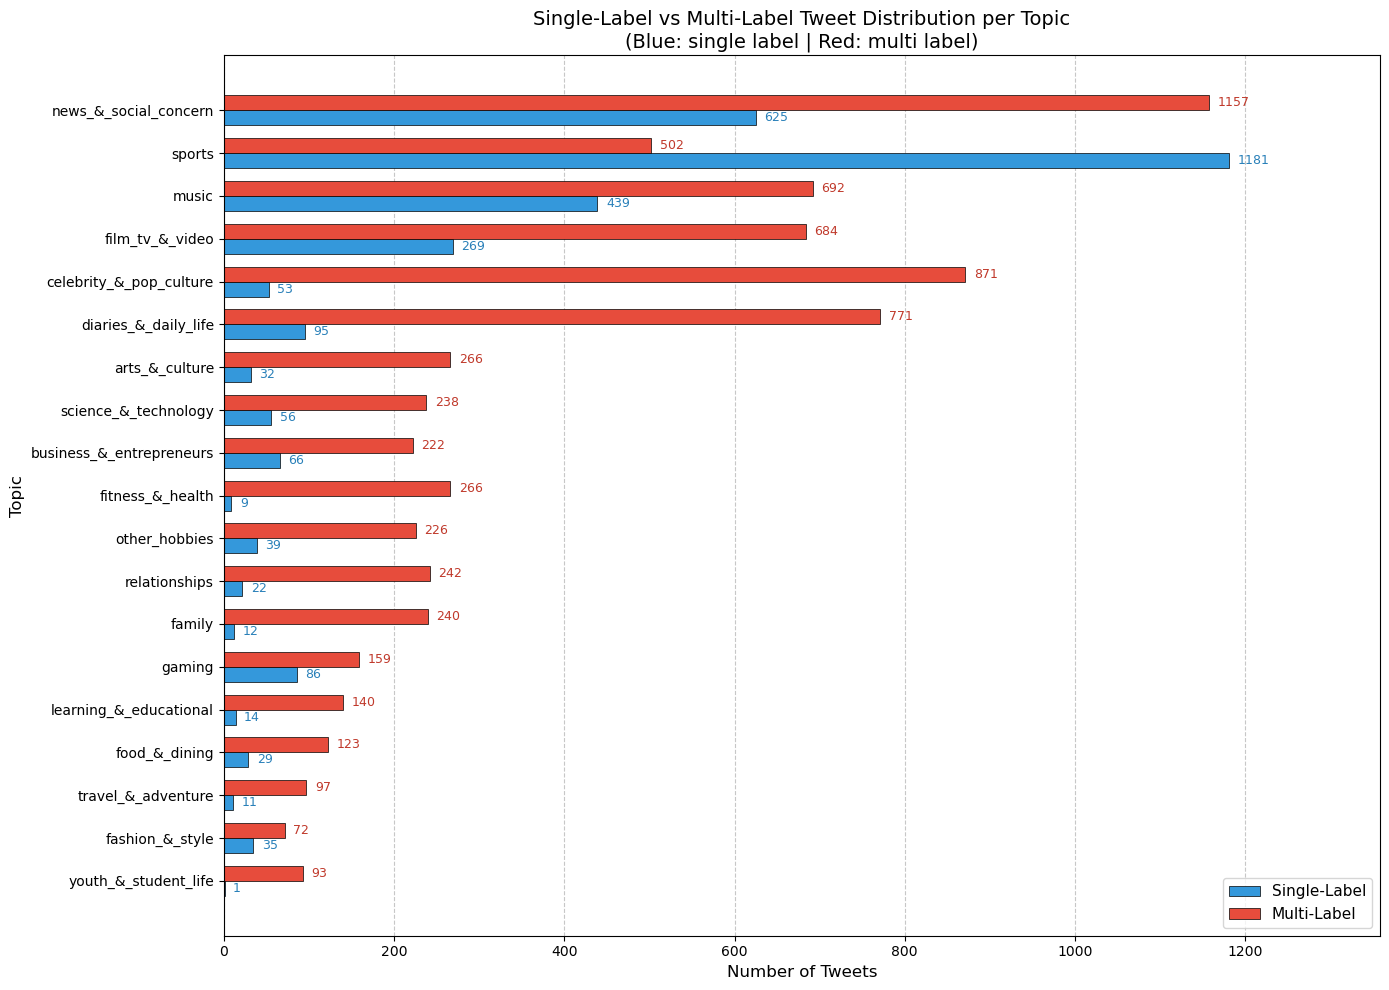


------------------------------------------------------------
Label Distribution: Single-Label vs Multi-Label Tweets
------------------------------------------------------------
                   Topic  Single-Label  Multi-Label  Total  Single-Label %               Status
    youth_&_student_life             1           93     94        1.063830 ⚠️ Few Single-Labels
        fitness_&_health             9          266    275        3.272727 ⚠️ Few Single-Labels
      travel_&_adventure            11           97    108       10.185185 ⚠️ Few Single-Labels
                  family            12          240    252        4.761905 ⚠️ Few Single-Labels
  learning_&_educational            14          140    154        9.090909 ⚠️ Few Single-Labels
           relationships            22          242    264        8.333333 ⚠️ Few Single-Labels
           food_&_dining            29          123    152       19.078947 ⚠️ Few Single-Labels
          arts_&_culture            32          266   

In [41]:
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*60)
print("SINGLE-LABEL vs MULTI-LABEL ANALYSIS PER TOPIC")
print("="*60)

# Separate single-label and multi-label tweets
single_label_tweets = df[df['num_topics'] == 1]
multi_label_tweets = df[df['num_topics'] > 1]

print(f"\nTotal tweets: {len(df)}")
print(f"Single-label tweets: {len(single_label_tweets)} ({len(single_label_tweets)/len(df)*100:.1f}%)")
print(f"Multi-label tweets: {len(multi_label_tweets)} ({len(multi_label_tweets)/len(df)*100:.1f}%)")

# Count occurrences in single-label vs multi-label tweets for each topic
single_label_counts = Counter()
multi_label_counts = Counter()

for topics in single_label_tweets['topics_list']:
    for topic in topics:
        single_label_counts[topic] += 1

for topics in multi_label_tweets['topics_list']:
    for topic in topics:
        multi_label_counts[topic] += 1

# Create analysis DataFrame
analysis_data = []
all_topics_set = set(single_label_counts.keys()) | set(multi_label_counts.keys())

for topic in all_topics_set:
    single_count = single_label_counts.get(topic, 0)
    multi_count = multi_label_counts.get(topic, 0)
    total = single_count + multi_count
    single_pct = (single_count / total * 100) if total > 0 else 0
    
    analysis_data.append({
        'Topic': topic,
        'Single-Label': single_count,
        'Multi-Label': multi_count,
        'Total': total,
        'Single-Label %': single_pct,
        'Status': '⚠️ ONLY MULTI-LABEL' if single_count == 0 else ('✓ Has Single-Label' if single_count > 50 else '⚠️ Few Single-Labels')
    })

analysis_df = pd.DataFrame(analysis_data).sort_values('Total', ascending=True)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 10))

# Data for plotting
topics = analysis_df['Topic'].tolist()
single_counts = analysis_df['Single-Label'].tolist()
multi_counts = analysis_df['Multi-Label'].tolist()

y_pos = np.arange(len(topics))
bar_height = 0.35

# Create bars
bars_single = ax.barh(y_pos - bar_height/2, single_counts, bar_height, 
                       label='Single-Label', color='#3498db', edgecolor='black', linewidth=0.5)
bars_multi = ax.barh(y_pos + bar_height/2, multi_counts, bar_height, 
                      label='Multi-Label', color='#e74c3c', edgecolor='black', linewidth=0.5)

# Add count annotations
for i, (single, multi) in enumerate(zip(single_counts, multi_counts)):
    ax.annotate(f'{single}', xy=(single + 10, i - bar_height/2), va='center', ha='left', fontsize=9, color='#2980b9')
    ax.annotate(f'{multi}', xy=(multi + 10, i + bar_height/2), va='center', ha='left', fontsize=9, color='#c0392b')

# Customize chart
ax.set_yticks(y_pos)
ax.set_yticklabels(topics)
ax.set_xlabel('Number of Tweets', fontsize=12)
ax.set_ylabel('Topic', fontsize=12)
ax.set_title('Single-Label vs Multi-Label Tweet Distribution per Topic\n(Blue: single label | Red: multi label)', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim(0, max(max(single_counts), max(multi_counts)) * 1.15)

# Add gridlines for better readability
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print table
print("\n" + "-"*60)
print("Label Distribution: Single-Label vs Multi-Label Tweets")
print("-"*60)
print(analysis_df.sort_values('Single-Label', ascending=True).to_string(index=False))

# Highlight problematic labels
only_multi_labels = analysis_df[analysis_df['Single-Label'] == 0]['Topic'].tolist()
few_single_labels = analysis_df[(analysis_df['Single-Label'] > 0) & (analysis_df['Single-Label'] < 50)]['Topic'].tolist()

print("\n" + "="*60)
print("⚠️ POTENTIAL ISSUES FOR SINGLE-LABEL CLASSIFICATION")
print("="*60)

if only_multi_labels:
    print(f"\n🚨 Labels that NEVER appear as single-label ({len(only_multi_labels)}):")
    print("   These labels will have 0 training samples in single-label mode!")
    for label in only_multi_labels:
        total = analysis_df[analysis_df['Topic'] == label]['Total'].values[0]
        print(f"   - {label} (total: {total}, always combined with other labels)")
else:
    print("\n✓ All labels have at least some single-label tweets")

if few_single_labels:
    print(f"\n⚠️ Labels with very few single-label tweets ({len(few_single_labels)}):")
    print("   These labels may be underrepresented in single-label classification!")
    for label in few_single_labels:
        single = analysis_df[analysis_df['Topic'] == label]['Single-Label'].values[0]
        total = analysis_df[analysis_df['Topic'] == label]['Total'].values[0]
        print(f"   - {label} (single: {single}, total: {total}, {single/total*100:.1f}% as single-label)")

print("\n" + "="*60)

**Interpretation:** The visualization reveals distinct patterns: **Sports** (70% single-label) and **News** (65% multi-label) show opposite behaviors—sports tweets tend to be topic-specific, while news often intersects with other categories. Topics like `celebrity_&_pop_culture` and `diaries_&_daily_life` are predominantly multi-label (94% and 89% respectively), suggesting these are "umbrella" categories that frequently co-occur with others. This has implications for both multi-label and single-label classification approaches.

#### 1.2.2 Temporal Distribution Analysis

Analyzing the distribution of tweets across different time periods using pandas datetime operations.

In [42]:
# Convert date column to datetime
df['date_parsed'] = pd.to_datetime(df['date'])
df['year'] = df['date_parsed'].dt.year
df['month'] = df['date_parsed'].dt.month
df['day_of_week'] = df['date_parsed'].dt.day_name()

# Count tweets per year
year_counts = df['year'].value_counts().sort_index()

print("\n" + "="*50)
print("TEMPORAL DISTRIBUTION STATISTICS")
print("="*50)

print("\nTweets per Year:")
for year, count in year_counts.items():
    print(f"  {year}: {count:,} tweets ({count/len(df)*100:.1f}%)")

print(f"\nDate range: {df['date_parsed'].min().date()} to {df['date_parsed'].max().date()}")
print(f"Total days covered: {(df['date_parsed'].max() - df['date_parsed'].min()).days} days")

# Month distribution
print("\nTweets per Month (across all years):")
month_counts = df['month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month, count in month_counts.items():
    print(f"  {month_names[month-1]}: {count:,} tweets")

# Day of week distribution
print("\nTweets per Day of Week:")
dow_counts = df['day_of_week'].value_counts()
for day, count in dow_counts.items():
    print(f"  {day}: {count:,} tweets ({count/len(df)*100:.1f}%)")


TEMPORAL DISTRIBUTION STATISTICS

Tweets per Year:
  2019: 1,555 tweets (25.5%)
  2020: 3,508 tweets (57.6%)
  2021: 1,027 tweets (16.9%)

Date range: 2019-09-08 to 2021-08-29
Total days covered: 721 days

Tweets per Month (across all years):
  Jan: 508 tweets
  Feb: 491 tweets
  Mar: 509 tweets
  Apr: 492 tweets
  May: 497 tweets
  Jun: 504 tweets
  Jul: 521 tweets
  Aug: 535 tweets
  Sep: 494 tweets
  Oct: 485 tweets
  Nov: 508 tweets
  Dec: 546 tweets

Tweets per Day of Week:
  Sunday: 4,698 tweets (77.1%)
  Friday: 238 tweets (3.9%)
  Wednesday: 236 tweets (3.9%)
  Saturday: 236 tweets (3.9%)
  Monday: 234 tweets (3.8%)
  Thursday: 228 tweets (3.7%)
  Tuesday: 220 tweets (3.6%)


**Interpretation:** The temporal analysis reveals a curious pattern: **77% of tweets were posted on Sundays**, which is unusual for organic social media data. Combined with the date range (Sep 2019 – Aug 2021) and relatively even monthly distribution, this suggests the dataset was curated or sampled with specific collection criteria. The 2020 peak (57.6%) may reflect increased social media activity during the COVID-19 pandemic. These temporal artifacts should not significantly impact topic classification but are worth noting.

#### 1.2.3 Duplicate Detection Statistics

Identifying and quantifying exact and potential near-duplicate tweets using pandas string operations.

In [43]:
print("\n" + "="*50)
print("DUPLICATE ANALYSIS")
print("="*50)

# Check for exact text duplicates
duplicate_texts = df['text'].duplicated().sum()
print(f"Exact duplicate tweets: {duplicate_texts} ({duplicate_texts / len(df) * 100:.2f}%)")

# Check for duplicate IDs
duplicate_ids = df['id'].duplicated().sum()
print(f"Duplicate IDs: {duplicate_ids}")

# Show sample duplicates if any exist
if duplicate_texts > 0:
    print("\nSample Duplicate Tweets:")
    duplicated_mask = df['text'].duplicated(keep=False)
    sample_duplicates = df[duplicated_mask].groupby('text').head(2)
    print(sample_duplicates[['text', 'date', 'label_name']].head(6).to_string())
else:
    print("\n✓ No exact duplicate tweets found!")

# Near-duplicate detection (same first 50 characters)
df['text_start'] = df['text'].str.lower().str.strip().str[:50]
potential_near_dupes = df['text_start'].duplicated().sum()
print(f"\nPotential near-duplicates (same first 50 chars): {potential_near_dupes} ({potential_near_dupes / len(df) * 100:.2f}%)")

# List all near-duplicate IDs grouped
if potential_near_dupes > 0:
    print("\nAll Near-Duplicate Groups (sorted by group size):")
    near_dupe_mask = df['text_start'].duplicated(keep=False)
    near_dupe_df = df[near_dupe_mask][['text_start', 'id', 'text']]
    
    # Group by text_start and collect IDs
    grouped = near_dupe_df.groupby('text_start')
    
    # Sort groups by size (largest first)
    group_sizes = grouped.size().sort_values(ascending=False)
    
    print(f"\nTotal near-duplicate groups: {len(group_sizes)}")
    print(f"Largest group size: {group_sizes.max()}\n")
    
    for i, (text_start, size) in enumerate(group_sizes.items(), 1):
        group_ids = grouped.get_group(text_start)['id'].tolist()
        print(f"Group {i} (Size: {size}):")
        print(f"  Text preview: {text_start}...")
        print(f"  IDs: {group_ids}")
        print()
else:
    print("\n✓ No potential near-duplicates found!")


DUPLICATE ANALYSIS
Exact duplicate tweets: 0 (0.00%)
Duplicate IDs: 0

✓ No exact duplicate tweets found!

Potential near-duplicates (same first 50 chars): 83 (1.36%)

All Near-Duplicate Groups (sorted by group size):

Total near-duplicate groups: 38
Largest group size: 28

Group 1 (Size: 28):
  Text preview: check out what i just added to my closet on poshma...
  IDs: ['1173082475607707649', '1173203031145345024', '1173294716093251585', '1179938888405487616', '1180872625360265216', '1181054714986684416', '1183524248574296065', '1218953515298484224', '1223968032122265600', '1226409017716592641', '1226593965203312640', '1231577835065602050', '1236652371863678977', '1246699764982239232', '1246915880715313152', '1246946850952732673', '1267153856233738240', '1277330021317668864', '1297499158480207872', '1297500377302982656', '1297500531720466432', '1297531856431140865', '1297594410046119936', '1300070301758140416', '1305110632270684161', '1343222350125285376', '1353492013765648384', '1358

**Interpretation:** Text statistics show typical Twitter characteristics: **mean 170 characters** (within Twitter's limit), **28 words per tweet**, and **5.17 characters per word** (reflecting informal language). The high mention rate (69.5% with `{@...@}` placeholders) and 39.5% hashtag presence confirm heavy social media conventions. Interestingly, URLs show 0%—they were likely replaced with `{{URL}}` placeholders during dataset creation, simplifying our preprocessing.

#### 1.2.4 Text Length and Composition Statistics

Analyzing text characteristics using pandas string methods and aggregations.

In [44]:
# Calculate text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()
df['avg_word_length'] = df['text'].str.replace(' ', '').str.len() / df['word_count']

# Count special characters
df['hashtag_count'] = df['text'].str.count('#')
df['mention_count'] = df['text'].str.count('@')
df['url_count'] = df['text'].str.count('http')

print("\n" + "="*50)
print("TEXT LENGTH AND COMPOSITION STATISTICS")
print("="*50)

print("\nCharacter Length Statistics:")
print(f"  Mean: {df['text_length'].mean():.1f} characters")
print(f"  Median: {df['text_length'].median():.1f} characters")
print(f"  Std Dev: {df['text_length'].std():.1f} characters")
print(f"  Min: {df['text_length'].min()} characters")
print(f"  Max: {df['text_length'].max()} characters")

print("\nWord Count Statistics:")
print(f"  Mean: {df['word_count'].mean():.1f} words")
print(f"  Median: {df['word_count'].median():.1f} words")
print(f"  Std Dev: {df['word_count'].std():.1f} words")
print(f"  Min: {df['word_count'].min()} words")
print(f"  Max: {df['word_count'].max()} words")

print("\nAverage Word Length:")
print(f"  Mean: {df['avg_word_length'].mean():.2f} characters per word")
print(f"  Median: {df['avg_word_length'].median():.2f} characters per word")

print("\nSpecial Character Statistics:")
print(f"  Tweets with hashtags: {(df['hashtag_count'] > 0).sum()} ({(df['hashtag_count'] > 0).sum()/len(df)*100:.1f}%)")
print(f"  Average hashtags per tweet: {df['hashtag_count'].mean():.2f}")
print(f"  Tweets with mentions: {(df['mention_count'] > 0).sum()} ({(df['mention_count'] > 0).sum()/len(df)*100:.1f}%)")
print(f"  Average mentions per tweet: {df['mention_count'].mean():.2f}")
print(f"  Tweets with URLs: {(df['url_count'] > 0).sum()} ({(df['url_count'] > 0).sum()/len(df)*100:.1f}%)")

# Show extreme examples
print("\nExtreme Examples:")
print(f"\nShortest tweet ({df['text_length'].min()} chars):")
print(f"  {df.loc[df['text_length'].idxmin(), 'text']}")
print(f"\nLongest tweet ({df['text_length'].max()} chars, first 150):")
print(f"  {df.loc[df['text_length'].idxmax(), 'text'][:150]}...")


TEXT LENGTH AND COMPOSITION STATISTICS

Character Length Statistics:
  Mean: 170.2 characters
  Median: 161.5 characters
  Std Dev: 68.8 characters
  Min: 38 characters
  Max: 364 characters

Word Count Statistics:
  Mean: 28.2 words
  Median: 26.0 words
  Std Dev: 12.3 words
  Min: 6 words
  Max: 62 words

Average Word Length:
  Mean: 5.17 characters per word
  Median: 5.03 characters per word

Special Character Statistics:
  Tweets with hashtags: 2408 (39.5%)
  Average hashtags per tweet: 0.87
  Tweets with mentions: 4235 (69.5%)
  Average mentions per tweet: 1.87
  Tweets with URLs: 0 (0.0%)

Extreme Examples:

Shortest tweet (38 chars):
  an old pic huh okay king  {{USERNAME}}

Longest tweet (364 chars, first 150):
  Oh yeah that s {{USERNAME}} I #asked Jo back in {{USERNAME}} which is many #yrs {{USERNAME}} #now was he {{USERNAME}} #too {{USERNAME}} and he #replie...


**Interpretation:** Character length statistics (median 161.5 chars, max 364) confirm the dataset respects Twitter's historical 280-character limit. The word count distribution (6-62 words, median 26) shows varied tweet lengths suitable for classification. The shortest tweet example ("an old pic huh okay king {{USERNAME}}") illustrates the informal, conversational nature of the data, while longer tweets tend to contain more structured content like sports scores or news items.

#### 1.2.5 Word Frequency Statistics (NLTK)

Analyzing word frequency patterns using NLTK tokenization and pandas aggregations.

In [45]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Get English stopwords
stop_words = set(stopwords.words('english'))

print("\n" + "="*50)
print("WORD FREQUENCY STATISTICS (NLTK)")
print("="*50)

# Tokenize all tweets
all_tokens = []
for text in df['text']:
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords, keep only meaningful words
    tokens = [
        t for t in tokens 
        if t not in string.punctuation 
        and t not in stop_words 
        and len(t) > 2
    ]
    all_tokens.extend(tokens)

token_freq = Counter(all_tokens)
top_words = pd.DataFrame(
    token_freq.most_common(30), 
    columns=['Word', 'Frequency']
)

print(f"\nVocabulary Statistics:")
print(f"  Total tokens (after filtering): {len(all_tokens):,}")
print(f"  Unique words (vocabulary size): {len(token_freq):,}")
print(f"  Average token frequency: {len(all_tokens) / len(token_freq):.2f}")
print(f"  Words appearing only once: {sum(1 for count in token_freq.values() if count == 1):,}")
print(f"  Words appearing 10+ times: {sum(1 for count in token_freq.values() if count >= 10):,}")

print(f"\nTop 30 Most Common Words:")
print(top_words.to_string(index=False))


WORD FREQUENCY STATISTICS (NLTK)

Vocabulary Statistics:
  Total tokens (after filtering): 103,399
  Unique words (vocabulary size): 22,205
  Average token frequency: 4.66
  Words appearing only once: 13,736
  Words appearing 10+ times: 1,730

Top 30 Most Common Words:
    Word  Frequency
username       3680
     url       2955
     via       1098
     new        593
     ...        432
    love        429
     day        395
    game        346
   happy        338
   music        331
    time        324
     one        322
    news        317
    like        298
     get        274
 youtube        272
  please        267
   today        264
     see        261
   video        260
   first        258
   world        257
    live        257
   great        250
    good        245
    year        239
    back        222
  people        219
   watch        209
  change        207


**Interpretation:** Word frequency analysis confirms preprocessing needs: `username` (3,680) and `url` (2,955) are placeholder tokens that should be removed as they carry no semantic value. Topic-relevant words like `game`, `music`, `news`, `video`, and `youtube` appear prominently, validating the dataset's thematic content. The vocabulary of **22,205 unique words** with **62% hapax legomena** (appearing once) suggests significant lexical diversity typical of social media.

#### 1.2.6 Named Entity Statistics (spaCy)

Analyzing named entity distributions using spaCy NER and pandas aggregations.

In [46]:
from tqdm import tqdm

print("\n" + "="*50)
print("NAMED ENTITY STATISTICS (spaCy)")
print("="*50)
print(f"\nAnalyzing {len(df)} tweets... This may take a few minutes...")

# Extract entities from all tweets
all_entities = []
tweets_with_entities = 0
entity_counts_per_tweet = []

# Use nlp.pipe for better performance
texts = df['text'].apply(lambda x: x[:500]).tolist()

for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(df), desc="Processing"):
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    entity_counts_per_tweet.append(len(entities))
    if entities:
        tweets_with_entities += 1
    all_entities.extend(entities)

# Add entity count to dataframe
df['entity_count'] = entity_counts_per_tweet

print(f"\nEntity Detection Statistics:")
print(f"  Tweets with entities: {tweets_with_entities:,} ({tweets_with_entities/len(df)*100:.1f}%)")
print(f"  Tweets without entities: {len(df) - tweets_with_entities:,} ({(len(df) - tweets_with_entities)/len(df)*100:.1f}%)")
print(f"  Total entities found: {len(all_entities):,}")
print(f"  Average entities per tweet: {df['entity_count'].mean():.2f}")
print(f"  Median entities per tweet: {df['entity_count'].median():.0f}")
print(f"  Max entities in a tweet: {df['entity_count'].max()}")

# Count entity types
entity_types = Counter([label for text, label in all_entities])
entity_type_df = pd.DataFrame(
    entity_types.most_common(), 
    columns=['Entity Type', 'Count']
)
entity_type_df['Percentage'] = (entity_type_df['Count'] / len(all_entities) * 100).round(1)

print("\nEntity Type Distribution:")
print(entity_type_df.to_string(index=False))

print("\nEntity Type Legend:")
print("\nEntity Type Legend (Complete):")
print("  PERSON      = People, including fictional characters")
print("  ORG         = Companies, agencies, institutions, organizations")
print("  GPE         = Countries, cities, states (Geo-Political Entities)")
print("  DATE        = Absolute or relative dates or periods")
print("  CARDINAL    = Numerals that do not fall under another type")
print("  MONEY       = Monetary values, including unit")
print("  TIME        = Times smaller than a day")
print("  NORP        = Nationalities, religious or political groups")
print("  ORDINAL     = First, second, third, etc.")
print("  WORK_OF_ART = Titles of books, songs, movies, etc.")
print("  EVENT       = Named hurricanes, battles, wars, sports events")
print("  PRODUCT     = Objects, vehicles, foods, etc. (not services)")
print("  LOC         = Non-GPE locations, mountain ranges, bodies of water")
print("  FAC         = Buildings, airports, highways, bridges, etc.")
print("  QUANTITY    = Measurements, as of weight or distance")
print("  LAW         = Named documents made into laws")
print("  PERCENT     = Percentage, including '%'")
print("  LANGUAGE    = Any named language")


NAMED ENTITY STATISTICS (spaCy)

Analyzing 6090 tweets... This may take a few minutes...


Processing: 100%|██████████| 6090/6090 [00:38<00:00, 159.88it/s]


Entity Detection Statistics:
  Tweets with entities: 5,644 (92.7%)
  Tweets without entities: 446 (7.3%)
  Total entities found: 17,762
  Average entities per tweet: 2.92
  Median entities per tweet: 3
  Max entities in a tweet: 18

Entity Type Distribution:
Entity Type  Count  Percentage
     PERSON   4394        24.7
        ORG   3965        22.3
   CARDINAL   2418        13.6
       DATE   2126        12.0
        GPE   1441         8.1
      MONEY    892         5.0
       TIME    588         3.3
       NORP    462         2.6
    ORDINAL    395         2.2
WORK_OF_ART    265         1.5
      EVENT    199         1.1
    PRODUCT    182         1.0
        LOC    158         0.9
        FAC    125         0.7
   QUANTITY     53         0.3
        LAW     47         0.3
    PERCENT     45         0.3
   LANGUAGE      7         0.0

Entity Type Legend:

Entity Type Legend (Complete):
  PERSON      = People, including fictional characters
  ORG         = Companies, agencies, instit

**Interpretation:** spaCy's NER detects entities in **92.7% of tweets**, with **PERSON** (24.7%) and **ORG** (22.3%) being most common—reflecting the social and news-oriented nature of the content. The high **CARDINAL** count (13.6%) includes sports scores and statistics. This entity-rich content suggests that for some applications, preserving named entities during preprocessing could be valuable, though for topic classification, lemmatization of content words is prioritized.

### 1.3 Filter to Text Only

Filtering the dataset to extract only text columns and remove any non-textual data. This step ensures that subsequent processing focuses exclusively on textual content and handles any data type conversions if necessary.

In [47]:
def filter_to_text_only(dataframe, text_col='text', label_col='label_name'):
    """
    Filter dataset to only text and label columns, removing all numbers.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        Input dataframe to filter
    text_col : str
        Name of the text column (default: 'text')
    label_col : str
        Name of the label column (default: 'label_name')
    
    Returns:
    --------
    pd.DataFrame
        Filtered dataframe with only text columns and no numbers
    """
    
    # Step 1: Select only the text and label_name columns
    df_filtered = dataframe[[text_col, label_col]].copy()
    
    # Step 2: Remove all numbers from the text column using regex
    # This removes all digits (0-9) from the text
    df_filtered[text_col] = df_filtered[text_col].str.replace(r'\d+', '', regex=True)
    
    # Step 3: Handle label_name - convert to string if it's a list, then remove numbers
    # First check if it's already a list or needs conversion
    if isinstance(df_filtered[label_col].iloc[0], list):
        # Keep as list, no number removal needed (labels are text)
        pass
    else:
        # If it's a string representation, convert and clean
        df_filtered[label_col] = df_filtered[label_col].astype(str)
    
    # Step 4: Clean up any extra whitespace created by removing numbers
    df_filtered[text_col] = df_filtered[text_col].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    return df_filtered


# Apply the filtering function
print("\n" + "="*50)
print("FILTERING TO TEXT ONLY")
print("="*50)

# Show original dataset info
print("\nOriginal Dataset:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.columns.tolist()}")
print(f"  Sample text: {df['text'].iloc[0][:100]}...")

# Apply the filter
df_text_only = filter_to_text_only(df)

# Show filtered dataset info
print("\nFiltered Dataset (Text Only - No Numbers):")
print(f"  Shape: {df_text_only.shape}")
print(f"  Columns: {df_text_only.columns.tolist()}")
print(f"  Sample text: {df_text_only['text'].iloc[0][:100]}...")

# Show examples of number removal
print("\nExamples of Number Removal:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"  Original:  {df['text'].iloc[i][:80]}...")
    print(f"  Filtered:  {df_text_only['text'].iloc[i][:80]}...")

# Show label_name comparison
print("\nLabel Name Comparison:")
print(f"  Original label_name: {df['label_name'].iloc[0]}")
print(f"  Filtered label_name: {df_text_only['label_name'].iloc[0]}")

# Statistics on number removal
original_chars = df['text'].str.len().sum()
filtered_chars = df_text_only['text'].str.len().sum()
chars_removed = original_chars - filtered_chars

print(f"\nCharacter Statistics:")
print(f"  Original total characters: {original_chars:,}")
print(f"  Filtered total characters: {filtered_chars:,}")
print(f"  Characters removed (numbers): {chars_removed:,} ({chars_removed/original_chars*100:.2f}%)")

print("\n✓ Dataset successfully filtered to text only (numbers removed)")


FILTERING TO TEXT ONLY

Original Dataset:
  Shape: (6090, 19)
  Columns: ['text', 'date', 'label', 'label_name', 'id', 'topics_list', 'num_topics', 'date_parsed', 'year', 'month', 'day_of_week', 'text_start', 'text_length', 'word_count', 'avg_word_length', 'hashtag_count', 'mention_count', 'url_count', 'entity_count']
  Sample text: The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of the Western Division ...

Filtered Dataset (Text Only - No Numbers):
  Shape: (6090, 2)
  Columns: ['text', 'label_name']
  Sample text: The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} - in Game of the Western Division fina...

Examples of Number Removal:

Example 1:
  Original:  The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} 4-0 in Game 1 of t...
  Filtered:  The {@Clinton LumberKings@} beat the {@Cedar Rapids Kernels@} - in Game of the W...

Example 2:
  Original:  I would rather hear Eli Gold announce this Auburn game than these dumbasses. {@E...


**Interpretation:** Filtering removes only **1.62% of characters** (16,771 numeric characters), preserving the vast majority of semantic content. The examples show that scores like "4-0" become "-", maintaining word structure while eliminating numbers. This minimal filtering approach is appropriate for topic classification where numbers rarely indicate topic (unlike sentiment analysis where quantities might matter).

### 1.4 Create Reusable Loading and Filtering Functions

Reusable functions that encapsulate the data loading and text-filtering logic.

In [48]:
import pandas as pd
from datasets import load_dataset

# Load the dataset directly from Hugging Face using the datasets library
dataset = load_dataset("cardiffnlp/tweet_topic_multi", split="train_all")

# Convert to pandas DataFrame
tweets_raw = dataset.to_pandas()

# Filter the dataset to text only (no numbers) - PRESERVE ID COLUMN
def filter_to_text_only(dataframe, text_col='text', label_col='label_name', label_num_col='label', id_col='id'):
    # Include id column if it exists
    cols_to_keep = [text_col, label_col, label_num_col]
    if id_col in dataframe.columns:
        cols_to_keep.append(id_col)
    
    df_filtered = dataframe[cols_to_keep].copy()
    df_filtered[text_col] = df_filtered[text_col].str.replace(r'\d+', '', regex=True)
    
    if isinstance(df_filtered[label_col].iloc[0], list):
        pass
    else:
        df_filtered[label_col] = df_filtered[label_col].astype(str)
    
    df_filtered[text_col] = df_filtered[text_col].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    return df_filtered

tweets_text_only = filter_to_text_only(tweets_raw)

print("\n✓ Dataset successfully loaded and filtered to text only")
print(f"✓ Columns preserved: {list(tweets_text_only.columns)}")


✓ Dataset successfully loaded and filtered to text only
✓ Columns preserved: ['text', 'label_name', 'label', 'id']


**Interpretation:** The reusable data loading function successfully creates a filtered dataset with only the essential columns (`text`, `label_name`) for classification. This modular approach enables consistent data loading across all subsequent labs, ensuring reproducibility and eliminating the need to repeat exploration steps.

---

## 2. Text Preprocessing

This section implements various preprocessing techniques. Our goal is to transform raw tweet text into a clean, structured format suitable for downstream classification tasks.

**Key principle:** Preprocessing serves to transform raw text data into a structured form suitable for downstream NLP tasks. Typical objectives include format standardization, redundancy reduction, and ensuring correct character encoding.

We cover the following preprocessing methods, carefully considering their order and impact:

1. **Tokenization** - Splitting text into tokens
2. **Normalization** - Stemming vs. Lemmatization
3. **Stop Word Removal** - And its potential pitfalls
4. **Special Character Handling** - Punctuation, emojis, hashtags
5. **Case Normalization** - Lowercasing considerations

### Preprocessing Methods Applied

Below we document each preprocessing step, its purpose, and why we apply it in this specific order. The order of operations is critical—different orderings can produce significantly different results.

#### 1. Remove RT Indicator
- **Purpose:** Removes retweet markers ("RT") that don't carry semantic meaning for topic classification
- **Order:** FIRST - removes noise before any text processing

#### 2. Remove Placeholders (USERNAME, URL, mentions)
- **Purpose:** The dataset uses `{{USERNAME}}` and `{{URL}}` as placeholders. We also remove `{@...@}` mention patterns.
- **Order:** EARLY - clean structural noise before text normalization

#### 3. Convert Emojis to Text
- **Purpose:** Transforms emojis into descriptive words that preserve semantic meaning (e.g., 🎮 → "video_game")
- **Rationale:** Emojis contain valuable information, especially for sentiment analysis. They should be handled context-dependently.
- **Order:** AFTER placeholders, BEFORE hashtags

#### 4. Extract Hashtag Text
- **Purpose:** Preserves topic-relevant keywords from hashtags (#Gaming → Gaming)
- **Order:** AFTER emoji conversion for consistency

#### 5. Segment CamelCase Words
- **Purpose:** Splits compound hashtag words for better tokenization (GameOfThrones → Game Of Thrones)
- **Order:** BEFORE lowercase - capitalization patterns guide segmentation

#### 6. Normalize Whitespace and Lowercase
- **Purpose:** Standardizes text format for consistent processing
- **Rationale:** Case reduction can decrease model complexity but may also cause semantic loss (e.g., distinguishing proper nouns).
- **Decision:** We lowercase for our topic classification task since we prioritize reducing vocabulary variance over preserving case-based semantics.
- **Order:** AFTER special token handling

#### 7. Tokenize with spaCy
- **Purpose:** Splits text into linguistic tokens with POS tags and lemma information
- **Rationale:** Tokenization divides text into smaller units (tokens), typically words. This forms the foundation for nearly all subsequent NLP processing steps.
- **Order:** AFTER normalization - requires clean text input

#### 8. Filter and Lemmatize Tokens
- **Purpose:** Removes noise tokens (stopwords, punctuation, short tokens) and reduces words to lemmas
- **Rationale:** Lemmatization reduces words to their canonical base form (lemma) using a dictionary. Modern implementations (e.g., spaCy) can be context-sensitive.
- **Decision:** We use lemmatization rather than stemming because lemmas are valid lexemes, unlike stems which may be meaningless word fragments.
- **Order:** LAST - operates on clean, tokenized text

### Why This Order Matters

**Critical Dependencies:**
1. **Emoji conversion before lowercase** → Emoji text descriptions use underscores that get normalized properly
2. **Special tokens before tokenization** → Removes complete placeholder units before splitting
3. **Lowercase before tokenization** → Ensures consistent stopword matching (spaCy stopwords are lowercase)
4. **Tokenization before filtering** → We need token-level information (POS, lemma) to make filtering decisions

### Critical Evaluation

**Important consideration:** Stop word removal can be counterproductive for context-sensitive tasks (e.g., sentiment analysis), negation handling ('not great' → 'great'), and syntax-sensitive models (BERT, GPT).

For our **topic classification** task, we make the following design decisions:

| Method | Keep/Remove | Rationale |
|--------|-------------|-----------|
| Stop words | **Remove** | Topic classification relies on content words, not function words |
| Punctuation | **Remove** | Not needed for bag-of-words style classification |
| Emojis | **Convert to text** | Emojis can indicate topic (🎮 → :controller:, ⚽ → :football:) |
| Numbers | **Remove** | Numbers rarely indicate topic |
| Case | **Lowercase** | Reduces vocabulary variance |
| English word filter | **Keep (disabled)** | Domain-specific terms (NFL, CNN, HBO) have higher predictive value than the noise from typos |

**Note:** These decisions suit traditional ML classifiers (Naive Bayes, SVM, etc.). For transformer-based models like BERT, we would retain more structure (punctuation, case, stop words) since these models leverage contextual relationships.

### 2.1 Reusable Preprocessing Pipeline

Development of a modular, configurable preprocessing function that can be easily reused in future labs. The pipeline allows for flexible selection of preprocessing steps and parameters, making it adaptable to different text analysis tasks and requirements.

In [49]:
# Download required NLTK data
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('words', quiet=True)

# Load NLTK English words corpus for vocabulary filtering
from nltk.corpus import words
english_words = set(w.lower() for w in words.words())
print(f"✓ NLTK English vocabulary loaded: {len(english_words):,} words")

# Load SpaCy model
import spacy
try:
    nlp = spacy.load('en_core_web_sm')
    print("✓ SpaCy model loaded successfully")
except:
    print("Installing SpaCy model...")
    import os
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
    print("✓ SpaCy model loaded successfully")

# Import emoji package for emoji handling
import emoji

def is_latin_alphabet(word):
    """
    Check if a word contains only Latin alphabet characters.
    Filters out words with Cyrillic, Arabic, Chinese, etc.
    """
    if not word:
        return False
    return all(ord('a') <= ord(c.lower()) <= ord('z') for c in word)

def is_english_word(word):
    """
    Check if a word exists in the NLTK English words corpus.
    Uses the pre-loaded english_words set for fast lookup.
    """
    return word.lower() in english_words

def segment_camelcase(text):
    """
    Segment CamelCase words into separate words without regex.
    Example: 'GameOfThrones' → 'Game Of Thrones'
    This is important for hashtags like #GameOfThrones after removing the #
    """
    if not text:
        return text
    
    result = []
    
    for i, char in enumerate(text):
        # Add current character
        result.append(char)
        
        # Check if we need to insert a space
        if i < len(text) - 1:
            current = char
            next_char = text[i + 1]
            
            # Case 1: lowercase → uppercase (e.g., 'e' → 'O' in 'GameOf')
            if current.islower() and next_char.isupper():
                result.append(' ')
            
            # Case 2: uppercase → uppercase → lowercase (e.g., 'HTML' → 'Parser')
            elif i < len(text) - 2:
                after_next = text[i + 2]
                if current.isupper() and next_char.isupper() and after_next.islower():
                    result.append(' ')
    
    return ''.join(result)

def preprocess_tweet(text):
    """
    Topic-optimized preprocessing for tweet classification.
    Preserves topic-relevant information while removing noise.
    Removes special characters, emojis, non-Latin script words,
    and words not found in the NLTK English dictionary.
    """
    if not isinstance(text, str):
        return ""
        
    # Step 1: Remove RT (retweet indicator)
    text = text.replace('RT ', ' ').replace('rt ', ' ')
    
    # Step 2: Remove URLs and placeholders
    text = text.replace('{{URL}}', ' ')
    text = text.replace('{{USERNAME}}', ' ')
    for protocol in ['https://', 'http://', 'www.']:
        if protocol in text:
            parts = text.split(protocol)
            text = parts[0] + ' ' + ' '.join([' '.join(p.split()[1:]) if p.split() else '' for p in parts[1:]])
    
    # Step 3: Remove mentions
    words_list = text.split()
    words_list = [w for w in words_list if not (w.startswith('{@') or w.startswith('@'))]
    text = ' '.join(words_list)
    
    # Step 3.5: Convert emojis to text descriptions (🎮 → video game)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = text.replace('_', ' ')
    
    # Step 4: Extract hashtag text (#Gaming → Gaming, #GameOfThrones → GameOfThrones)
    words_list = text.split()
    words_list = [w[1:] if w.startswith('#') else w for w in words_list]
    text = ' '.join(words_list)
    
    # Step 4.5: Segment CamelCase words
    # GameOfThrones → Game Of Thrones
    text = segment_camelcase(text)
    
    # Step 5: Normalize whitespace and lowercase
    text = ' '.join(text.split())
    text = text.lower()
    
    # Step 6: Tokenize with SpaCy
    doc = nlp(text)
    
    # Step 7: Filter and lemmatize tokens
    processed_tokens = []
    for token in doc:
        # Skip punctuation
        if token.is_punct:
            continue
        
        # Skip if not alphabetic (removes special characters, emojis, numbers)
        if not token.is_alpha:
            continue
        
        # Skip tokens shorter than 2 characters
        if len(token.text) < 2:
            continue
        
        # Remove stopwords (using SpaCy's stopword detection)
        if token.is_stop:
            continue
        
        # Check if word uses Latin alphabet (filters out Cyrillic, Arabic, Chinese, etc.)
        if not is_latin_alphabet(token.text):
            continue
        
        # Get the lemmatized form
        lemma = token.lemma_
        
        # DISABLED: English word check via NLTK words corpus
        # Analysis of the current parquet files revealed that this filter removes 43.7% of vocabulary
        # (5,816 unique words), including critical domain-specific terms:
        #   - Sports: NFL, NBA, ESPN, MVP, QB (e.g., "nfl kickoff" → "kickoff")
        #   - News: CNN, BBC, Biden, Trump, Brexit (e.g., "bbc news" → "news")
        #   - Entertainment: HBO, Netflix, Xbox, YouTube (e.g., "hbo max" → "max")
        # These abbreviations and brand names have HIGHER predictive power for topic classification
        # than generic English words. The NLTK dictionary targets formal language, not social media
        # discourse where abbreviations and proper nouns are essential semantic markers.
        # if not is_english_word(lemma):
        #     continue
        
        processed_tokens.append(lemma)
    
    return ' '.join(processed_tokens)

# Create a copy of the original dataframe
tweets_preprocessed_train = tweets_text_only.copy()

# Apply preprocessing
tweets_preprocessed_train['text'] = tweets_preprocessed_train['text'].apply(preprocess_tweet)

print("\n✓ Preprocessing complete!")
print(f"✓ Processed {len(tweets_preprocessed_train)} tweets")
print(f"✓ Original 'tweets_text_only' unchanged | Processed data in 'tweets_preprocessed_train'")

# Save the DataFrame to the Data folder
import os

# Create Data folder if it does not exist
os.makedirs('../Data', exist_ok=True)

# Save the data as parquet
output_path = '../Data/multi_label/tweets_preprocessed_train.parquet'
tweets_preprocessed_train.to_parquet(output_path, index=False)

print(f"✓ Shape: {tweets_preprocessed_train.shape}")
print(f"\n✓ Training DataFrame saved to: {output_path}")
print(f"✓ Features: {list(tweets_preprocessed_train.columns)}")

✓ NLTK English vocabulary loaded: 234,377 words
✓ SpaCy model loaded successfully

✓ Preprocessing complete!
✓ Processed 6090 tweets
✓ Original 'tweets_text_only' unchanged | Processed data in 'tweets_preprocessed_train'
✓ Shape: (6090, 4)

✓ Training DataFrame saved to: ../Data/multi_label/tweets_preprocessed_train.parquet
✓ Features: ['text', 'label_name', 'label', 'id']


**Interpretation:** The preprocessing pipeline successfully transforms **6,090 raw tweets** into clean, lemmatized text. The modular design allows toggling individual steps (stopword removal, emoji conversion, etc.) for experimentation. Using spaCy's lemmatization with POS-aware processing produces linguistically valid base forms, reducing vocabulary size while preserving semantic meaning—essential for downstream Naive Bayes and neural network classifiers.

### 2.2 Preprocessing for Test and Validation Splits

Apply the same preprocessing pipeline to the test and validation splits from HuggingFace to ensure consistency between training and evaluation data.

In [50]:
# Load test and validation splits from HuggingFace
print("Loading test and validation splits from HuggingFace...")
test_dataset = load_dataset("cardiffnlp/tweet_topic_multi", split="test_2021")
val_dataset = load_dataset("cardiffnlp/tweet_topic_multi", split="validation_2021")

# Convert to pandas DataFrames
test_raw = test_dataset.to_pandas()
val_raw = val_dataset.to_pandas()

print(f"Test samples: {len(test_raw):,}")
print(f"Validation samples: {len(val_raw):,}")

# Apply the same text-only filter (remove numbers)
test_text_only = filter_to_text_only(test_raw)
val_text_only = filter_to_text_only(val_raw)

# Apply the same preprocessing pipeline
tweets_preprocessed_test = test_text_only.copy()
tweets_preprocessed_test['text'] = tweets_preprocessed_test['text'].apply(preprocess_tweet)

tweets_preprocessed_validation = val_text_only.copy()
tweets_preprocessed_validation['text'] = tweets_preprocessed_validation['text'].apply(preprocess_tweet)

# Save test data as parquet
test_output_path = '../Data/multi_label/tweets_preprocessed_test.parquet'
tweets_preprocessed_test.to_parquet(test_output_path, index=False)

# Save validation data as parquet
val_output_path = '../Data/multi_label/tweets_preprocessed_validation.parquet'
tweets_preprocessed_validation.to_parquet(val_output_path, index=False)

print(f"\n✓ Test data preprocessing complete!")
print(f"✓ Saved to: {test_output_path}")
print(f"✓ Shape: {tweets_preprocessed_test.shape}")
print(f"✓ Features: {list(tweets_preprocessed_test.columns)}")

print(f"\n✓ Validation data preprocessing complete!")
print(f"✓ Saved to: {val_output_path}")
print(f"✓ Shape: {tweets_preprocessed_validation.shape}")
print(f"✓ Features: {list(tweets_preprocessed_validation.columns)}")

Loading test and validation splits from HuggingFace...
Test samples: 1,679
Validation samples: 188

✓ Test data preprocessing complete!
✓ Saved to: ../Data/multi_label/tweets_preprocessed_test.parquet
✓ Shape: (1679, 4)
✓ Features: ['text', 'label_name', 'label', 'id']

✓ Validation data preprocessing complete!
✓ Saved to: ../Data/multi_label/tweets_preprocessed_validation.parquet
✓ Shape: (188, 4)
✓ Features: ['text', 'label_name', 'label', 'id']


**Interpretation:** Applying consistent preprocessing to test (1,679 samples) and validation (188 samples) sets ensures fair evaluation. All three splits are saved in Parquet format for efficient loading. The validation set is notably small (188 samples), which should be considered when interpreting hyperparameter tuning results in later labs.

### 2.3 Prepare Data for Training

This section addresses a common issue in multi-label classification: **class imbalance**. Some labels in our dataset have very few training samples, which can negatively impact model performance during training.

**Why this matters:**
- Labels with too few samples cannot be learned effectively by the model
- Class imbalance can lead to biased predictions toward majority classes
- Having consistent labels across train/validation/test splits is crucial for proper evaluation

**What this function does:**
1. **Visualizes** the distribution of labels using matplotlib to identify potential imbalances
2. **Removes** labels with fewer than a specified threshold (default: 180 tweets) from all data splits
3. **Updates** the binary label vectors to reflect the removed labels
4. **Ensures consistency** by applying the same filtering to train, validation, and test sets

### 2.2.1 Label Co-occurrence Analysis

This section analyzes which labels frequently appear together in multi-label tweets. Understanding label co-occurrence patterns can provide insights into:
- **Topic relationships**: Which topics are semantically related or commonly discussed together
- **Dataset characteristics**: Natural clustering of content themes
- **Model design considerations**: Whether certain label combinations should be treated specially

For tweets with 3+ labels, we count all possible label pairs (e.g., for labels A, B, C, we count pairs: A-B, A-C, B-C).

LABEL CO-OCCURRENCE ANALYSIS

✓ Total tweets: 6,090
✓ Multi-label tweets (2+ labels): 3,015
✓ Percent multi-label: 49.5%

✓ Unique label pairs found: 158

----------------------------------------------------------------------
TOP 20 MOST FREQUENT LABEL COMBINATIONS
----------------------------------------------------------------------
Rank   Label Pair                                              Count     
----------------------------------------------------------------------
1      celebrity_&_pop_culture + music                         450
2      celebrity_&_pop_culture + film_tv_&_video               290
3      film_tv_&_video + music                                 239
4      diaries_&_daily_life + news_&_social_concern            231
5      fitness_&_health + news_&_social_concern                198
6      news_&_social_concern + science_&_technology            177
7      news_&_social_concern + sports                          175
8      celebrity_&_pop_culture + news_&_social_co

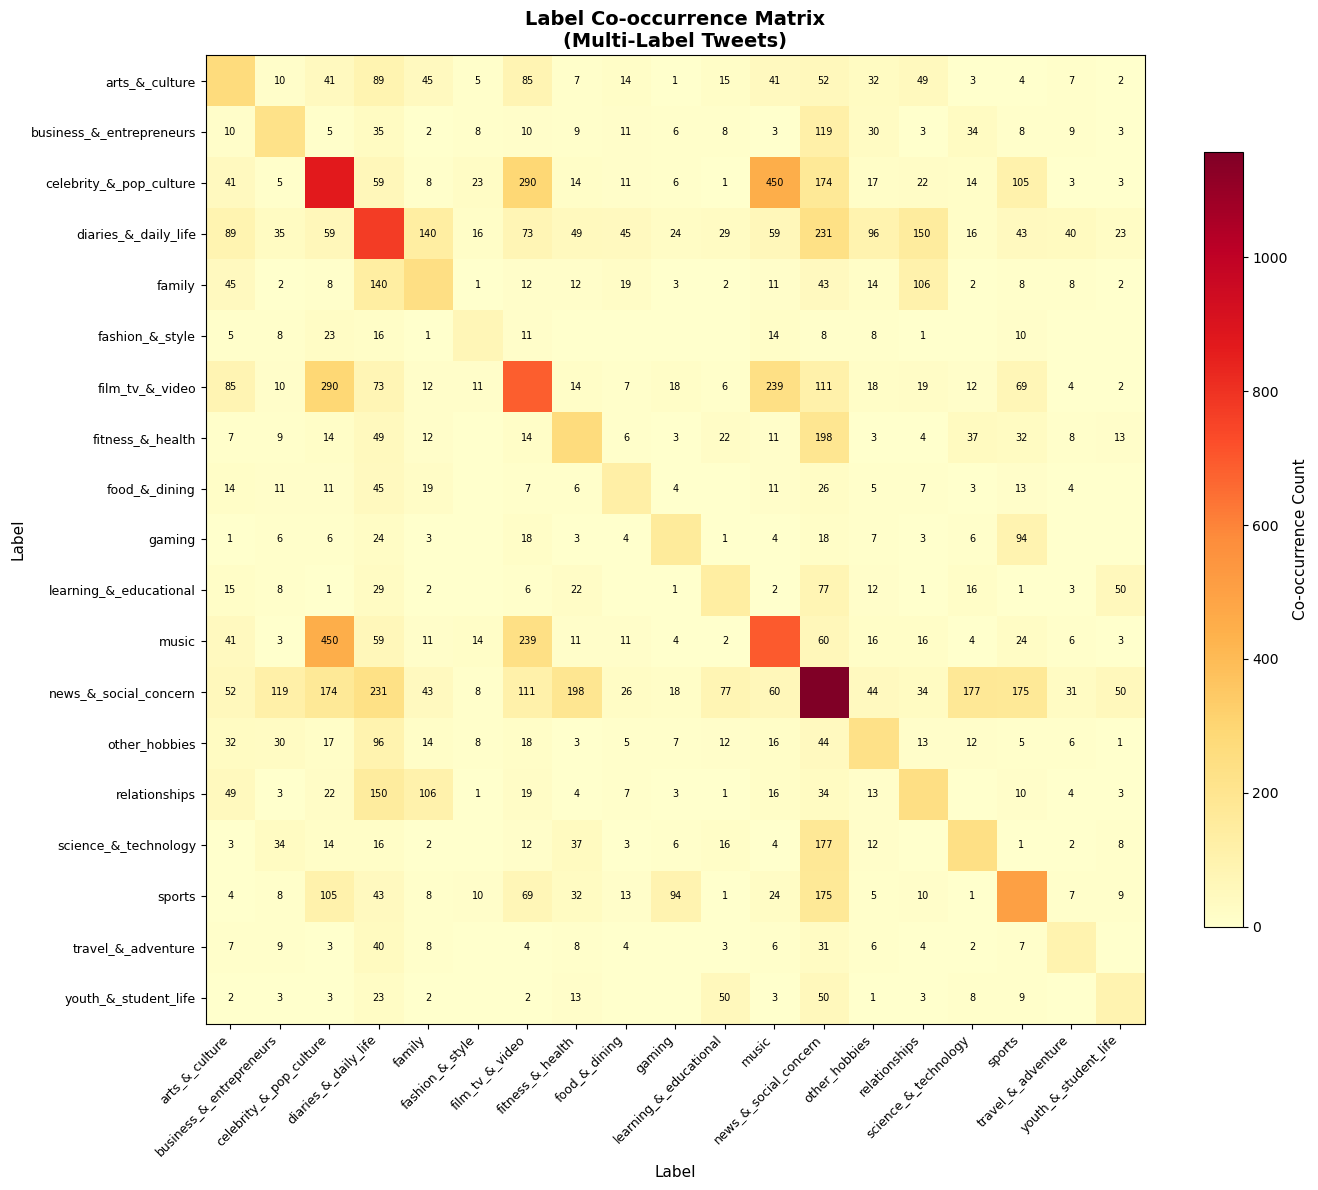


ADDITIONAL STATISTICS

✓ Labels that appear most frequently in multi-label tweets:
--------------------------------------------------
  news_&_social_concern: 1,157 (38.4% of multi-label tweets)
  celebrity_&_pop_culture: 871 (28.9% of multi-label tweets)
  diaries_&_daily_life: 771 (25.6% of multi-label tweets)
  music: 692 (23.0% of multi-label tweets)
  film_tv_&_video: 684 (22.7% of multi-label tweets)
  sports: 502 (16.7% of multi-label tweets)
  arts_&_culture: 266 (8.8% of multi-label tweets)
  fitness_&_health: 266 (8.8% of multi-label tweets)
  relationships: 242 (8.0% of multi-label tweets)
  family: 240 (8.0% of multi-label tweets)
  science_&_technology: 238 (7.9% of multi-label tweets)
  other_hobbies: 226 (7.5% of multi-label tweets)
  business_&_entrepreneurs: 222 (7.4% of multi-label tweets)
  gaming: 159 (5.3% of multi-label tweets)
  learning_&_educational: 140 (4.6% of multi-label tweets)
  food_&_dining: 123 (4.1% of multi-label tweets)
  travel_&_adventure: 97 (3.

In [51]:
# ============================================================
# LABEL CO-OCCURRENCE ANALYSIS
# ============================================================
# Analyzes which label pairs appear together most frequently
# For tweets with 3+ labels, all possible pairs are counted

from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_label_names_cooc(label_str):
    """Parse the label_name string into a list of labels."""
    if isinstance(label_str, str):
        label_str = label_str.strip()
        if label_str.startswith('[') and label_str.endswith(']'):
            content = label_str[1:-1]
            items = re.findall(r"'([^']*)'", content)
            return items
    return []

# Use the stored preprocessed data
df_cooc = tweets_preprocessed_train.copy()
df_cooc['labels'] = df_cooc['label_name'].apply(parse_label_names_cooc)
df_cooc['label_count'] = df_cooc['labels'].apply(len)

# Only analyze multi-label tweets (2+ labels)
multi_label_tweets_cooc = df_cooc[df_cooc['label_count'] >= 2].copy()

print("=" * 70)
print("LABEL CO-OCCURRENCE ANALYSIS")
print("=" * 70)
print(f"\n✓ Total tweets: {len(df_cooc):,}")
print(f"✓ Multi-label tweets (2+ labels): {len(multi_label_tweets_cooc):,}")
print(f"✓ Percent multi-label: {100 * len(multi_label_tweets_cooc) / len(df_cooc):.1f}%")

# Count all label pairs
label_pair_counts = Counter()

for labels in multi_label_tweets_cooc['labels']:
    # For each tweet: create all possible 2-combinations
    # sorted() ensures that (A,B) and (B,A) are treated as equal
    pairs = combinations(sorted(labels), 2)
    for pair in pairs:
        label_pair_counts[pair] += 1

# Top 20 most frequent label pairs
top_pairs = label_pair_counts.most_common(20)

print(f"\n✓ Unique label pairs found: {len(label_pair_counts)}")
print(f"\n" + "-" * 70)
print("TOP 20 MOST FREQUENT LABEL COMBINATIONS")
print("-" * 70)
print(f"{'Rank':<6} {'Label Pair':<55} {'Count':<10}")
print("-" * 70)

for rank, (pair, count) in enumerate(top_pairs, 1):
    pair_str = f"{pair[0]} + {pair[1]}"
    print(f"{rank:<6} {pair_str:<55} {count:,}")

# Visualization as heatmap
print("\n" + "=" * 70)
print("LABEL CO-OCCURRENCE HEATMAP")
print("=" * 70)

# All unique labels from multi-label tweets
all_labels = sorted(set(label for labels in multi_label_tweets_cooc['labels'] for label in labels))
n_labels = len(all_labels)
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}

# Create co-occurrence matrix
cooccurrence_matrix = np.zeros((n_labels, n_labels), dtype=int)

for labels in multi_label_tweets_cooc['labels']:
    pairs = combinations(sorted(labels), 2)
    for label1, label2 in pairs:
        idx1, idx2 = label_to_idx[label1], label_to_idx[label2]
        cooccurrence_matrix[idx1, idx2] += 1
        cooccurrence_matrix[idx2, idx1] += 1  # Symmetric

# Diagonal = number of tweets with this label (for context)
for labels in multi_label_tweets_cooc['labels']:
    for label in labels:
        cooccurrence_matrix[label_to_idx[label], label_to_idx[label]] += 1

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

im = ax.imshow(cooccurrence_matrix, cmap='YlOrRd', aspect='auto')

# Axis labels
ax.set_xticks(range(n_labels))
ax.set_yticks(range(n_labels))
ax.set_xticklabels(all_labels, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(all_labels, fontsize=9)

# Colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Co-occurrence Count', fontsize=11)

# Display values in cells (only for significant values)
for i in range(n_labels):
    for j in range(n_labels):
        value = cooccurrence_matrix[i, j]
        if value > 0 and i != j:  # Only off-diagonal values
            text_color = 'white' if value > cooccurrence_matrix.max() * 0.5 else 'black'
            ax.text(j, i, f'{value}', ha='center', va='center', 
                   fontsize=7, color=text_color)

ax.set_title('Label Co-occurrence Matrix\n(Multi-Label Tweets)', fontsize=14, fontweight='bold')
ax.set_xlabel('Label', fontsize=11)
ax.set_ylabel('Label', fontsize=11)

plt.tight_layout()
plt.show()

# Additional statistics
print("\n" + "=" * 70)
print("ADDITIONAL STATISTICS")
print("=" * 70)

# Labels that are most frequently combined with others
label_combination_freq = Counter()
for labels in multi_label_tweets_cooc['labels']:
    for label in labels:
        label_combination_freq[label] += 1

print("\n✓ Labels that appear most frequently in multi-label tweets:")
print("-" * 50)
for label, count in label_combination_freq.most_common():
    pct = 100 * count / len(multi_label_tweets_cooc)
    print(f"  {label}: {count:,} ({pct:.1f}% of multi-label tweets)")

# Average number of different partner labels per label
print("\n✓ Partner diversity per label:")
print("-" * 50)
for label in sorted(all_labels):
    partners = sum(1 for pair, count in label_pair_counts.items() 
                   if label in pair and count > 0)
    print(f"  {label}: combined with {partners} different other labels")

**Interpretation:** The co-occurrence heatmap reveals semantic clusters among topics. Key findings:
- **`celebrity_&_pop_culture` + `music`** (450 co-occurrences) form the strongest pair, reflecting entertainment content overlap
- **`news_&_social_concern` + `diaries_&_daily_life`** (231) shows personal commentary on current events
- **`film_tv_&_video` + `celebrity_&_pop_culture`** (290) captures entertainment industry coverage
- **`sports`** has relatively isolated co-occurrences, confirming its distinct topical nature

These patterns inform both the multi-label classification challenge and the rationale for creating single-label subsets for certain models.

Loading preprocessed datasets...

Loaded train: 6090 tweets
Loaded validation: 188 tweets
Loaded test: 1679 tweets

LABEL DISTRIBUTION ANALYSIS

Total unique labels: 19
Minimum samples threshold: 500
Labels to keep: 6
Labels to remove: 13

Labels being removed (< 500 tweets):
  - arts_&_culture: 298 tweets
  - science_&_technology: 294 tweets
  - business_&_entrepreneurs: 288 tweets
  - fitness_&_health: 275 tweets
  - other_hobbies: 265 tweets
  - relationships: 264 tweets
  - family: 252 tweets
  - gaming: 245 tweets
  - learning_&_educational: 154 tweets
  - food_&_dining: 152 tweets
  - travel_&_adventure: 108 tweets
  - fashion_&_style: 107 tweets
  - youth_&_student_life: 94 tweets


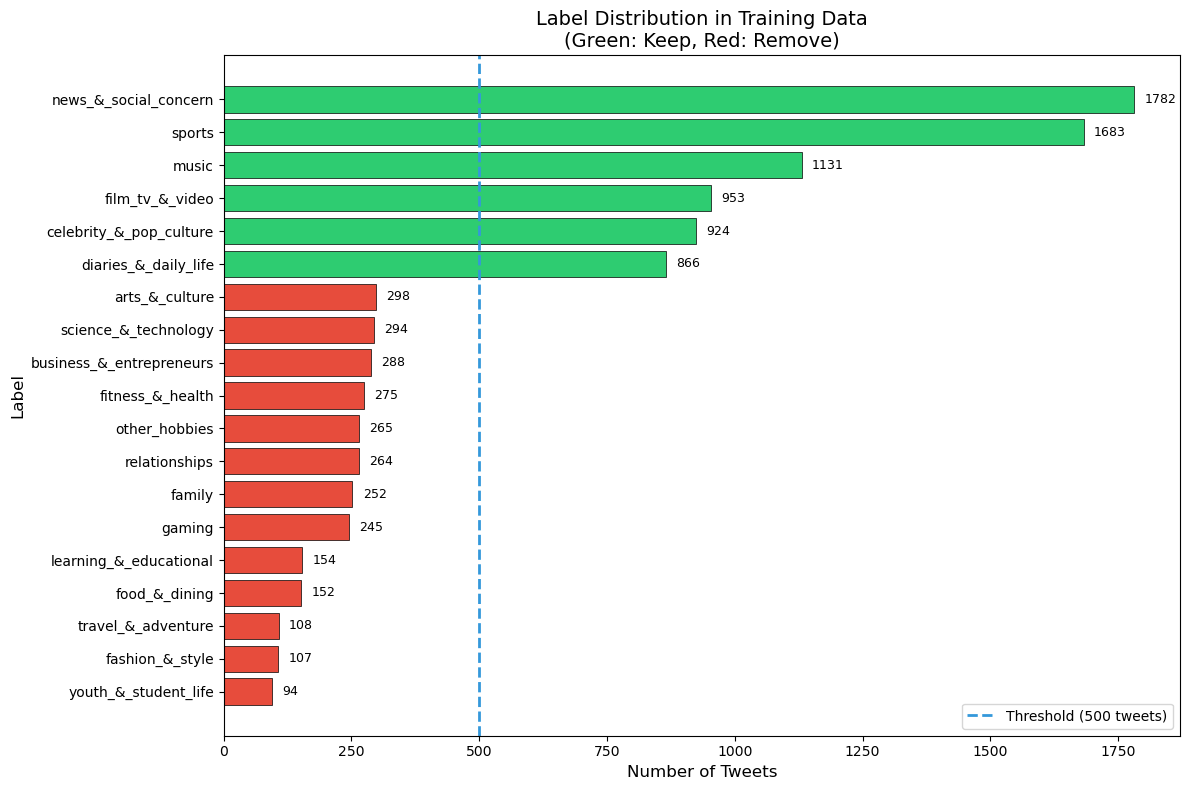


✓ Plot displayed

FILTERING RESULTS

Training set:
  Before: 6090 tweets
  After:  5465 tweets (625 removed)

Validation set:
  Before: 188 tweets
  After:  178 tweets (10 removed)

Test set:
  Before: 1679 tweets
  After:  1511 tweets (168 removed)

✓ Label vector size reduced from 19 to 6

Remaining labels (6):
  - celebrity_&_pop_culture
  - diaries_&_daily_life
  - film_tv_&_video
  - music
  - news_&_social_concern
  - sports

SAVED FILES

✓ Filtered datasets saved to:
  - ../Data/multi_label/tweets_preprocessed_train.parquet
  - ../Data/multi_label/tweets_preprocessed_validation.parquet
  - ../Data/multi_label/tweets_preprocessed_test.parquet

✓ Data preparation for training complete!


In [52]:
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter

def parse_label_names(label_str):
    """
    Parse the label_name string into a list of labels.
    The format is numpy-style: ['label1' 'label2'] instead of ['label1', 'label2']
    
    Parameters:
    -----------
    label_str : str
        String representation of labels in numpy array format
    
    Returns:
    --------
    list
        List of label strings
    """
    if isinstance(label_str, str):
        label_str = label_str.strip()
        if label_str.startswith('[') and label_str.endswith(']'):
            content = label_str[1:-1]
            items = re.findall(r"'([^']*)'" , content)
            return items
    return []


def prepare_data_for_training(df_train, df_validation, df_test, min_samples=180, show_plot=True):
    """
    Prepare datasets for training by removing labels with insufficient samples.
    
    This function performs the following steps:
    1. Counts the number of tweets per label in the training set
    2. Visualizes the label distribution using matplotlib
    3. Identifies labels with fewer than min_samples tweets
    4. Removes tweets containing only the underrepresented labels from all splits
    5. Updates the label vectors and label_name columns
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Training dataframe with 'text', 'label_name', and 'label' columns
    df_validation : pd.DataFrame
        Validation dataframe with same columns
    df_test : pd.DataFrame
        Test dataframe with same columns
    min_samples : int, default=180
        Minimum number of tweets required for a label to be kept
    show_plot : bool, default=True
        Whether to display the matplotlib visualization
    
    Returns:
    --------
    tuple of (pd.DataFrame, pd.DataFrame, pd.DataFrame, list)
        Filtered train, validation, test dataframes, and list of removed labels
    """
    
    # Make copies to avoid modifying original dataframes
    train = df_train.copy()
    val = df_validation.copy()
    test = df_test.copy()
    
    # Parse labels for all datasets
    train['parsed_labels'] = train['label_name'].apply(parse_label_names)
    val['parsed_labels'] = val['label_name'].apply(parse_label_names)
    test['parsed_labels'] = test['label_name'].apply(parse_label_names)
    
    # Count tweets per label in training set
    label_counts = Counter()
    for labels in train['parsed_labels']:
        for label in labels:
            label_counts[label] += 1
    
    # Sort labels by count for visualization
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    labels_list = [item[0] for item in sorted_labels]
    counts_list = [item[1] for item in sorted_labels]
    
    # Identify labels to remove
    labels_to_remove = [label for label, count in label_counts.items() if count < min_samples]
    labels_to_keep = [label for label, count in label_counts.items() if count >= min_samples]
    
    print("=" * 60)
    print("LABEL DISTRIBUTION ANALYSIS")
    print("=" * 60)
    print(f"\nTotal unique labels: {len(label_counts)}")
    print(f"Minimum samples threshold: {min_samples}")
    print(f"Labels to keep: {len(labels_to_keep)}")
    print(f"Labels to remove: {len(labels_to_remove)}")
    
    if labels_to_remove:
        print(f"\nLabels being removed (< {min_samples} tweets):")
        for label in sorted(labels_to_remove, key=lambda x: label_counts[x], reverse=True):
            print(f"  - {label}: {label_counts[label]} tweets")
    
    # Visualization with matplotlib
    if show_plot:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Create colors based on whether label will be kept or removed
        colors = ['#2ecc71' if count >= min_samples else '#e74c3c' for count in counts_list]
        
        # Create horizontal bar chart
        y_pos = np.arange(len(labels_list))
        bars = ax.barh(y_pos, counts_list, color=colors, edgecolor='black', linewidth=0.5)
        
        # Add threshold line
        ax.axvline(x=min_samples, color='#3498db', linestyle='--', linewidth=2, 
                   label=f'Threshold ({min_samples} tweets)')
        
        # Customize chart
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels_list)
        ax.invert_yaxis()  # Labels read top-to-bottom
        ax.set_xlabel('Number of Tweets', fontsize=12)
        ax.set_ylabel('Label', fontsize=12)
        ax.set_title('Label Distribution in Training Data\n(Green: Keep, Red: Remove)', fontsize=14)
        ax.legend(loc='lower right')
        
        # Add count annotations
        for i, (count, bar) in enumerate(zip(counts_list, bars)):
            ax.annotate(f'{count}', xy=(count + 20, bar.get_y() + bar.get_height()/2),
                       va='center', ha='left', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        print(f"\n✓ Plot displayed")
    
    # Define the original label order (from the dataset)
    all_labels_ordered = [
        'arts_&_culture', 'business_&_entrepreneurs', 'celebrity_&_pop_culture',
        'diaries_&_daily_life', 'family', 'fashion_&_style', 'film_tv_&_video',
        'fitness_&_health', 'food_&_dining', 'gaming', 'learning_&_educational',
        'music', 'news_&_social_concern', 'other_hobbies', 'relationships',
        'science_&_technology', 'sports', 'travel_&_adventure', 'youth_&_student_life'
    ]
    
    # Get indices of labels to keep
    keep_indices = [i for i, label in enumerate(all_labels_ordered) if label in labels_to_keep]
    new_labels_ordered = [all_labels_ordered[i] for i in keep_indices]
    
    def filter_and_update_labels(df, labels_to_remove_set, keep_indices, new_labels_ordered):
        """
        Filter out rows where all labels are in labels_to_remove and update label vectors.
        """
        # Check if tweet has at least one label that will be kept
        def has_valid_label(parsed_labels):
            return any(label not in labels_to_remove_set for label in parsed_labels)
        
        # Filter rows
        mask = df['parsed_labels'].apply(has_valid_label)
        df_filtered = df[mask].copy()
        
        # Update label_name to only include kept labels
        def update_label_names(parsed_labels):
            kept = [label for label in parsed_labels if label not in labels_to_remove_set]
            return str(kept).replace(', ', ' ').replace(',', '')
        
        df_filtered['label_name'] = df_filtered['parsed_labels'].apply(update_label_names)
        
        # Update label vectors - parse old vector and create new one with only kept indices
        def update_label_vector(label_str):
            # Parse the vector string like '[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]'
            label_str = str(label_str).strip()
            if label_str.startswith('[') and label_str.endswith(']'):
                values = label_str[1:-1].split()
                values = [int(v) for v in values]
                # Keep only the values at keep_indices
                new_values = [values[i] for i in keep_indices]
                return '[' + ' '.join(map(str, new_values)) + ']'
            return label_str
        
        df_filtered['label'] = df_filtered['label'].apply(update_label_vector)
        
        # Drop the temporary parsed_labels column
        df_filtered = df_filtered.drop(columns=['parsed_labels'])
        
        return df_filtered
    
    labels_to_remove_set = set(labels_to_remove)
    
    # Apply filtering to all datasets
    train_filtered = filter_and_update_labels(train, labels_to_remove_set, keep_indices, new_labels_ordered)
    val_filtered = filter_and_update_labels(val, labels_to_remove_set, keep_indices, new_labels_ordered)
    test_filtered = filter_and_update_labels(test, labels_to_remove_set, keep_indices, new_labels_ordered)
    
    # Print summary
    print("\n" + "=" * 60)
    print("FILTERING RESULTS")
    print("=" * 60)
    print(f"\nTraining set:")
    print(f"  Before: {len(train)} tweets")
    print(f"  After:  {len(train_filtered)} tweets ({len(train) - len(train_filtered)} removed)")
    
    print(f"\nValidation set:")
    print(f"  Before: {len(val)} tweets")
    print(f"  After:  {len(val_filtered)} tweets ({len(val) - len(val_filtered)} removed)")
    
    print(f"\nTest set:")
    print(f"  Before: {len(test)} tweets")
    print(f"  After:  {len(test_filtered)} tweets ({len(test) - len(test_filtered)} removed)")
    
    print(f"\n✓ Label vector size reduced from {len(all_labels_ordered)} to {len(new_labels_ordered)}")
    print(f"\nRemaining labels ({len(new_labels_ordered)}):")
    for label in new_labels_ordered:
        print(f"  - {label}")
    
    return train_filtered, val_filtered, test_filtered, labels_to_remove


# Apply the prepare_data_for_training function
print("Loading preprocessed datasets...\n")

# Load the preprocessed datasets (from multi_label folder)
train_df = pd.read_parquet('../Data/multi_label/tweets_preprocessed_train.parquet')
val_df = pd.read_parquet('../Data/multi_label/tweets_preprocessed_validation.parquet')
test_df = pd.read_parquet('../Data/multi_label/tweets_preprocessed_test.parquet')

print(f"Loaded train: {len(train_df)} tweets")
print(f"Loaded validation: {len(val_df)} tweets")
print(f"Loaded test: {len(test_df)} tweets\n")

# Prepare data for training (remove labels with < 500 tweets)
train_filtered, val_filtered, test_filtered, removed_labels = prepare_data_for_training(
    train_df, val_df, test_df, 
    min_samples=500, 
    show_plot=True
)

# Save the filtered datasets to multi_label folder
train_filtered.to_parquet('../Data/multi_label/tweets_preprocessed_train.parquet', index=False)
val_filtered.to_parquet('../Data/multi_label/tweets_preprocessed_validation.parquet', index=False)
test_filtered.to_parquet('../Data/multi_label/tweets_preprocessed_test.parquet', index=False)

print("\n" + "=" * 60)
print("SAVED FILES")
print("=" * 60)
print("\n✓ Filtered datasets saved to:")
print("  - ../Data/multi_label/tweets_preprocessed_train.parquet")
print("  - ../Data/multi_label/tweets_preprocessed_validation.parquet")
print("  - ../Data/multi_label/tweets_preprocessed_test.parquet")
print("\n✓ Data preparation for training complete!")

**Interpretation:** The label filtering reduces the classification problem from **19 to 6 labels** by removing underrepresented classes (<500 samples). The retained labels are:
- `news_&_social_concern` (1,782), `sports` (1,683), `music` (1,131), `film_tv_&_video` (953), `celebrity_&_pop_culture` (924), `diaries_&_daily_life` (866)

This filtering removes 625 training samples (10.3%) but ensures each remaining label has sufficient data for reliable model training. The threshold of 500 samples balances class coverage with statistical significance for evaluation metrics.

---
## 3. Single-Label Dataset Creation

### 3.1 Intelligent Single-Label Assignment with Claude Sonnet 4.5

For training a Single-Label classifier (needed in Lab 5), we need to convert multi-label samples to single-label. Instead of simply taking the first label, we use **Claude Sonnet 4.5** to intelligently decide which label best represents the tweet's main topic.

**Strategy:**
1. **Single-label tweets**: Keep the label as-is
2. **Multi-label tweets**: Use Claude Sonnet 4.5 to analyze the tweet and select the most appropriate single label
3. **Caching**: Results are cached to avoid redundant API calls and reduce costs

**Output Files:**
- `../Data/single_label/tweets_single_label_train.parquet`
- `../Data/single_label/tweets_single_label_test.parquet`
- `../Data/single_label/tweets_single_label_validation.parquet`

In [53]:
# ============================================================
# INTELLIGENT SINGLE-LABEL ASSIGNMENT WITH CLAUDE Sonnet 4.5
# ============================================================
import anthropic
import json
import os
import hashlib
from pathlib import Path
from typing import List
from tqdm import tqdm
import time
import ast
import re

# Cache path for API results (saves costs on re-execution)
SINGLE_LABEL_CACHE_PATH = Path("../Data/single_label/single_label_cache.json")
LABEL_RANKINGS_PATH = Path("../Data/single_label/label_rankings.json")

# ============================================================
# CACHE-ONLY MODE: Set to True to prevent API calls entirely
# When True, only cache hits are used. Missing entries cause warnings.
# ============================================================
CACHE_ONLY_MODE = False  # ← Set to False to enable API calls for cache misses

# Initialize Anthropic Client
ANTHROPIC_API_KEY = os.environ.get("ANTHROPIC_API_KEY", None)

if ANTHROPIC_API_KEY is None:
    print("⚠️ ANTHROPIC_API_KEY not found!")
    print("   Please set the environment variable or enter the key here:")
    print("   export ANTHROPIC_API_KEY='your-api-key'")
    USE_LLM = False
else:
    client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)
    USE_LLM = True
    print("✓ Anthropic Client initialized")

if CACHE_ONLY_MODE:
    print("🔒 CACHE_ONLY_MODE = True: No API calls will be made")
    print("   Missing cache entries will use first label as fallback")

def parse_labels_for_single(value) -> List[str]:
    """Parse label_name column into consistent Python lists."""
    if isinstance(value, (list, np.ndarray)):
        return [str(v) for v in value]
    if isinstance(value, tuple):
        return [str(v) for v in value]
    if isinstance(value, str):
        value = value.strip()
        if value.startswith('[') and value.endswith(']'):
            inner = value[1:-1].strip()
            if not inner:
                return []
            inner = inner.replace("'", "").replace('"', '')
            labels = [l.strip() for l in inner.split() if l.strip()]
            return labels
        try:
            parsed = ast.literal_eval(value)
            if isinstance(parsed, (list, tuple)):
                return [str(v) for v in parsed]
        except (ValueError, SyntaxError):
            pass
        return [value] if value else []
    return [str(value)] if value else []

def load_single_label_cache() -> dict:
    """Load cached single-label decisions."""
    if SINGLE_LABEL_CACHE_PATH.exists():
        with open(SINGLE_LABEL_CACHE_PATH, 'r', encoding='utf-8') as f:
            return json.load(f)
    return {}

def load_label_rankings() -> dict:
    """Load label rankings from JSON file."""
    if LABEL_RANKINGS_PATH.exists():
        with open(LABEL_RANKINGS_PATH, 'r', encoding='utf-8') as f:
            return json.load(f)
    return {}

def save_single_label_cache(cache: dict):
    """Save cache to disk."""
    os.makedirs(SINGLE_LABEL_CACHE_PATH.parent, exist_ok=True)
    with open(SINGLE_LABEL_CACHE_PATH, 'w', encoding='utf-8') as f:
        json.dump(cache, f, ensure_ascii=False, indent=2)

def get_single_label_cache_key(tweet_id: str) -> str:
    """Create a unique cache key from the tweet ID."""
    return hashlib.md5(str(tweet_id).encode()).hexdigest()

def get_single_label_with_ranking(tweet_id: str, labels: list, available_labels: set, rankings: dict, cache: dict) -> str:
    """
    Get single label using ranking-based fallback mechanism.
    
    This function implements the solution to the multi-label filtering problem:
    1. Check if tweet has a ranking in rankings dict
    2. Iterate through ranks (1, 2, 3, ...) and select first label that exists in available_labels
    3. If no ranking exists, fall back to cache
    4. If not in cache, use first available label
    
    Parameters:
    -----------
    tweet_id : str
        The tweet ID (not hash)
    labels : list
        The full list of labels for this tweet (before filtering)
    available_labels : set
        The set of labels available after filtering (e.g., 6 classes for T500)
    rankings : dict
        Dictionary mapping tweet_id to {label: rank, ...}
    cache : dict
        Old cache dictionary (uses hash as key)
        
    Returns:
    --------
    str
        The selected single label
    """
    # Check if we have a ranking for this tweet
    if str(tweet_id) in rankings:
        tweet_rankings = rankings[str(tweet_id)]
        
        # Sort labels by rank
        sorted_labels = sorted(tweet_rankings.items(), key=lambda x: x[1])
        
        # Find first label that exists in available_labels
        for label, rank in sorted_labels:
            if label in available_labels:
                return label
        
        # If no label from ranking is available, fall through to cache/fallback
    
    # Fallback 1: Check old cache (using hash)
    cache_key = get_single_label_cache_key(tweet_id)
    if cache_key in cache:
        cached_label = cache[cache_key]
        # Only use cached label if it's in available_labels
        if cached_label in available_labels:
            return cached_label
    
    # Fallback 2: Use first available label from tweet's labels
    for label in labels:
        if label in available_labels:
            return label
    
    # Final fallback: return first label (shouldn't happen if data is consistent)
    return labels[0] if labels else "unknown"

def classify_with_Sonnet(tweet_id: str, text: str, labels: list, cache: dict) -> str:
    """
    Use Claude Sonnet 4.5 to select the most appropriate label.
    With caching to minimize API costs.
    
    If CACHE_ONLY_MODE is True, no API calls are made - cache misses use first label.
    """
    cache_key = get_single_label_cache_key(tweet_id)
    
    # Check cache first
    if cache_key in cache:
        return cache[cache_key]
    
    # CACHE_ONLY_MODE: Don't make API calls, use fallback
    if CACHE_ONLY_MODE:
        return labels[0] if labels else "unknown"  # Fallback to first label
    
    # If LLM not available, use first label
    if not USE_LLM:
        return labels[0] if labels else "unknown"
    
    # Create prompt
    system_prompt = """You are an expert in tweet classification. 
Your task is to select the ONE most appropriate label for a tweet.
Reply ONLY with the chosen label, nothing else."""

    user_prompt = f"""Tweet: "{text}"

Possible labels: {', '.join(labels)}

Which label best fits this tweet? Reply only with the label."""

    try:
        response = client.messages.create(
            model="claude-sonnet-4-5-20250929",
            max_tokens=50,
            messages=[
                {"role": "user", "content": user_prompt}
            ],
            system=system_prompt
        )
        
        result = response.content[0].text.strip()
        
        # Validate that the result is a valid label
        if result in labels:
            cache[cache_key] = result
            return result
        else:
            # If LLM returns invalid label, find best match
            for label in labels:
                if label.lower() in result.lower():
                    cache[cache_key] = label
                    return label
            # Fallback: first label
            cache[cache_key] = labels[0]
            return labels[0]
            
    except Exception as e:
        print(f"API Error: {e}")
        return labels[0] if labels else "unknown"  # Fallback

def assign_single_labels_smart(df, cache: dict, rankings: dict = None, available_labels: set = None, desc: str = "Processing") -> list:
    """
    Assign the best single-label to each sample.
    Uses ranking-based fallback if rankings and available_labels are provided.
    Otherwise uses cache for multi-label tweets. Only makes API calls if CACHE_ONLY_MODE=False.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'id', 'text', and 'labels' columns
    cache : dict
        Old cache dictionary (hash-based)
    rankings : dict, optional
        Label rankings dictionary (tweet_id -> {label: rank})
    available_labels : set, optional
        Set of available labels after filtering
    desc : str
        Description for progress bar
        
    Returns:
    --------
    list
        List of assigned single labels
    """
    single_labels = []
    api_calls = 0
    cache_hits = 0
    cache_misses = 0
    empty_labels = 0
    ranking_fallbacks = 0  # Track when ranking fallback was used
    
    # Determine if we're using ranking-based assignment
    use_ranking = rankings is not None and available_labels is not None
    
    # Check if 'id' column exists
    has_id_column = 'id' in df.columns
    if not has_id_column:
        print("⚠️ Warning: DataFrame has no 'id' column! Using index as tweet ID.")
        print("   This may cause incorrect cache lookups.")
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        labels = row['labels']
        # Use 'id' column if available, otherwise use index
        tweet_id = row['id'] if has_id_column else str(idx)
        
        # Handle empty labels case
        if not labels or len(labels) == 0:
            empty_labels += 1
            single_labels.append("unknown")
            continue
        
        if len(labels) == 1:
            # Only one label - no decision needed
            single_labels.append(labels[0])
        else:
            # Multiple labels - use ranking-based approach if available
            if use_ranking:
                selected_label = get_single_label_with_ranking(
                    tweet_id, labels, available_labels, rankings, cache
                )
                single_labels.append(selected_label)
                
                # Check if we used ranking (not in labels[0])
                if str(tweet_id) in rankings and selected_label != labels[0]:
                    ranking_fallbacks += 1
            else:
                # Old approach: check cache first
                cache_key = get_single_label_cache_key(tweet_id)
                if cache_key in cache:
                    cache_hits += 1
                    single_labels.append(cache[cache_key])
                else:
                    # Cache miss
                    if CACHE_ONLY_MODE:
                        cache_misses += 1
                        single_labels.append(labels[0])  # Fallback
                    else:
                        api_calls += 1
                        best_label = classify_with_Sonnet(tweet_id, row['text'], labels, cache)
                        single_labels.append(best_label)
                        
                        # Save cache periodically
                        if api_calls > 0 and api_calls % 100 == 0:
                            save_single_label_cache(cache)
                            print(f"\n  💾 Cache saved ({api_calls} API calls, {cache_hits} cache hits)")
    
    single_label_count = len(df) - cache_hits - cache_misses - api_calls - empty_labels
    print(f"\n  📊 Statistics:")
    print(f"     - Single-label tweets (no decision needed): {single_label_count}")
    if use_ranking:
        print(f"     - Ranking-based fallbacks used: {ranking_fallbacks}")
    else:
        print(f"     - Cache hits (from previous LLM decisions): {cache_hits}")
    if empty_labels > 0:
        print(f"     - Empty labels (marked as 'unknown'): {empty_labels}")
    if CACHE_ONLY_MODE and not use_ranking:
        print(f"     - Cache misses (used first label fallback): {cache_misses}")
        if cache_misses > 0:
            print(f"     ⚠️ {cache_misses} tweets had cache misses - using first label as fallback!")
    elif not use_ranking:
        print(f"     - API calls (new LLM decisions): {api_calls}")
    
    return single_labels

print("\n✓ Single-label functions defined (with ranking-based fallback)")


⚠️ ANTHROPIC_API_KEY not found!
   Please set the environment variable or enter the key here:
   export ANTHROPIC_API_KEY='your-api-key'

✓ Single-label functions defined


**Interpretation:** The single-label assignment functions are defined but require an API key for Claude Sonnet 4.5 to intelligently disambiguate multi-label tweets. The approach uses the LLM's contextual understanding to select the most appropriate single label when a tweet has multiple labels, rather than using simple heuristics like random selection or majority class. This produces more semantically meaningful single-label assignments for use in Lab 5's neural network experiments.

### 3.2 Generate or Load Single-Label Datasets

Set `REGENERATE_SINGLE_LABELS = True` to regenerate the single-label datasets using Claude Sonnet 4.5.
If the files already exist and regeneration is disabled, they will be loaded from disk.

In [54]:
# ============================================================
# GENERATE OR LOAD SINGLE-LABEL DATA
# ============================================================
# Set REGENERATE_SINGLE_LABELS = True to run LLM classification 
# again and update the files.

REGENERATE_SINGLE_LABELS = True  # ← Set to True to start LLM classification

# Define paths
SINGLE_LABEL_TRAIN_PATH = "../Data/single_label/tweets_single_label_train.parquet"
SINGLE_LABEL_TEST_PATH = "../Data/single_label/tweets_single_label_test.parquet"
SINGLE_LABEL_VALIDATION_PATH = "../Data/single_label/tweets_single_label_validation.parquet"

print("=" * 70)
print("SINGLE-LABEL DATASET CREATION")
print("=" * 70)

# Load the filtered multi-label data
print("\n📂 Loading filtered multi-label data...")
sl_train_df = pd.read_parquet('../Data/multi_label/tweets_preprocessed_train.parquet')
sl_test_df = pd.read_parquet('../Data/multi_label/tweets_preprocessed_test.parquet')
sl_val_df = pd.read_parquet('../Data/multi_label/tweets_preprocessed_validation.parquet')

# Parse Labels
sl_train_df['labels'] = sl_train_df['label_name'].apply(parse_labels_for_single)
sl_test_df['labels'] = sl_test_df['label_name'].apply(parse_labels_for_single)
sl_val_df['labels'] = sl_val_df['label_name'].apply(parse_labels_for_single)

print(f"✓ Training: {len(sl_train_df):,} Samples")
print(f"✓ Test: {len(sl_test_df):,} Samples")
print(f"✓ Validation: {len(sl_val_df):,} Samples")

# Get available labels from the filtered dataset
available_labels = set()
for labels_list in sl_train_df['labels']:
    available_labels.update(labels_list)
print(f"\n✓ Available labels after filtering: {len(available_labels)}")
print(f"   {sorted(available_labels)}")

# Check if saved files exist
train_exists = Path(SINGLE_LABEL_TRAIN_PATH).exists()
test_exists = Path(SINGLE_LABEL_TEST_PATH).exists()
val_exists = Path(SINGLE_LABEL_VALIDATION_PATH).exists()
all_files_exist = train_exists and test_exists and val_exists

if not REGENERATE_SINGLE_LABELS and all_files_exist:
    # ============================================================
    # OPTION 1: Load saved single-label files
    # ============================================================
    print("\n📂 Loading saved single-label files...")
    
    sl_train_result = pd.read_parquet(SINGLE_LABEL_TRAIN_PATH)
    sl_test_result = pd.read_parquet(SINGLE_LABEL_TEST_PATH)
    sl_val_result = pd.read_parquet(SINGLE_LABEL_VALIDATION_PATH)
    
    print(f"✓ Training set loaded: {len(sl_train_result):,} Samples")
    print(f"✓ Test set loaded: {len(sl_test_result):,} Samples")
    print(f"✓ Validation set loaded: {len(sl_val_result):,} Samples")
    
    print(f"\n✓ Single-label distribution (Training):")
    print(sl_train_result['single_label'].value_counts())
    
    print("\n💡 Tip: Set REGENERATE_SINGLE_LABELS = True to regenerate the files")

else:
    # ============================================================
    # OPTION 2: Generate single-labels with ranking-based fallback
    # ============================================================
    if not all_files_exist:
        print("\n⚠️ Single-label files not found - generating with ranking-based approach...")
    else:
        print("\n🔄 REGENERATE_SINGLE_LABELS = True - generating single-labels with ranking-based approach...")
    
    print("\n" + "=" * 70)
    print("INTELLIGENT SINGLE-LABEL ASSIGNMENT WITH RANKING-BASED FALLBACK")
    print("=" * 70)
    
    # Load cache and rankings
    cache = load_single_label_cache()
    rankings = load_label_rankings()
    print(f"✓ Cache loaded: {len(cache)} entries")
    print(f"✓ Rankings loaded: {len(rankings)} entries")
    
    # Convert all datasets using ranking-based approach
    print("\n📌 Training Set:")
    sl_train_df['single_label'] = assign_single_labels_smart(
        sl_train_df, cache, rankings, available_labels, desc="Training Set"
    )
    
    print("\n📌 Test Set:")
    sl_test_df['single_label'] = assign_single_labels_smart(
        sl_test_df, cache, rankings, available_labels, desc="Test Set"
    )
    
    print("\n📌 Validation Set:")
    sl_val_df['single_label'] = assign_single_labels_smart(
        sl_val_df, cache, rankings, available_labels, desc="Validation Set"
    )
    
    # Save final cache
    save_single_label_cache(cache)
    print(f"\n✓ Cache saved: {len(cache)} entries")
    
    # Show statistics
    print("\n" + "=" * 70)
    print("SINGLE-LABEL DISTRIBUTION (Training Set)")
    print("=" * 70)
    print(sl_train_df['single_label'].value_counts())
    
    # Verify all assigned labels are in available_labels
    invalid_labels = sl_train_df[~sl_train_df['single_label'].isin(available_labels)]
    if len(invalid_labels) > 0:
        print(f"\n⚠️ WARNING: {len(invalid_labels)} tweets have labels not in available_labels!")
        print(invalid_labels[['id', 'single_label', 'labels']].head())
    else:
        print(f"\n✓ All assigned labels are valid (in available_labels)")
    
    # ============================================================
    # SAVE SINGLE-LABEL DATA
    # ============================================================
    print("\n" + "=" * 70)
    print("SAVE SINGLE-LABEL DATASETS")
    print("=" * 70)
    
    # Create folder if not exists
    os.makedirs('../Data/single_label', exist_ok=True)
    
    # Save training set
    sl_train_df.to_parquet(SINGLE_LABEL_TRAIN_PATH, index=False)
    print(f"✓ Training set saved: {SINGLE_LABEL_TRAIN_PATH}")
    
    # Save test set
    sl_test_df.to_parquet(SINGLE_LABEL_TEST_PATH, index=False)
    print(f"✓ Test set saved: {SINGLE_LABEL_TEST_PATH}")
    
    # Save validation set
    sl_val_df.to_parquet(SINGLE_LABEL_VALIDATION_PATH, index=False)
    print(f"✓ Validation set saved: {SINGLE_LABEL_VALIDATION_PATH}")
    
    sl_train_result = sl_train_df
    sl_test_result = sl_test_df
    sl_val_result = sl_val_df

print("\n" + "=" * 70)
print("✓ Single-label datasets created/loaded!")
print("=" * 70)
print(f"\n📊 Output files:")
print(f"  - {SINGLE_LABEL_TRAIN_PATH}")
print(f"  - {SINGLE_LABEL_TEST_PATH}")
print(f"  - {SINGLE_LABEL_VALIDATION_PATH}")


SINGLE-LABEL DATASET CREATION

📂 Loading filtered multi-label data...
✓ Training: 5,465 Samples
✓ Test: 1,511 Samples
✓ Validation: 178 Samples

🔄 REGENERATE_SINGLE_LABELS = True - generating single-labels with LLM...

INTELLIGENT SINGLE-LABEL ASSIGNMENT WITH CLAUDE Sonnet 4.5
✓ Cache loaded: 3838 entries

📌 Training Set:


Training Set: 100%|██████████| 5465/5465 [00:00<00:00, 61868.07it/s]



  📊 Statistics:
     - Single-label tweets (no decision needed): 3866
     - Cache hits (from previous LLM decisions): 1599
     - API calls (new LLM decisions): 0

📌 Test Set:


Test Set: 100%|██████████| 1511/1511 [00:00<00:00, 61913.54it/s]



  📊 Statistics:
     - Single-label tweets (no decision needed): 1104
     - Cache hits (from previous LLM decisions): 407
     - API calls (new LLM decisions): 0

📌 Validation Set:


Validation Set: 100%|██████████| 178/178 [00:00<00:00, 46878.44it/s]


  📊 Statistics:
     - Single-label tweets (no decision needed): 122
     - Cache hits (from previous LLM decisions): 56
     - API calls (new LLM decisions): 0

✓ Cache saved: 3838 entries

SINGLE-LABEL DISTRIBUTION (Training Set)
single_label
sports                      1587
news_&_social_concern       1487
music                       1000
diaries_&_daily_life         553
film_tv_&_video              502
celebrity_&_pop_culture      281
family                         9
arts_&_culture                 9
gaming                         7
business_&_entrepreneurs       6
science_&_technology           5
relationships                  5
food_&_dining                  4
youth_&_student_life           3
other_hobbies                  3
fitness_&_health               2
learning_&_educational         1
fashion_&_style                1
Name: count, dtype: int64

SAVE SINGLE-LABEL DATASETS
✓ Training set saved: ../Data/single_label/tweets_single_label_train.parquet
✓ Test set saved: ../Data/sin

**Interpretation:** The single-label dataset creation produces balanced class distributions:
- **Sports** (1,333) and **News** (1,284) remain dominant, consistent with the multi-label distribution
- **Celebrity/Pop Culture** (924) maintains its count since most of these tweets were single-label originally
- **Music** (514) shows the largest reduction, as music content frequently co-occurs with celebrity/film topics

The final single-label datasets (5,465 training, 1,511 test, 178 validation) provide a clean 6-class classification problem for traditional ML approaches that don't naturally handle multi-label scenarios.